faktorid:
- piirkond 
- mitu treeingandmepuntki on
	- piirkonnas
	- kokku
- bpointide arv piirkonnas (+-lisa nt50%)

mõõdikud
- piirkonna treening- vs testviga
  - * treening vs test abs ja suht
  - samadel X, erineva müraga
  - X_grid
- 2-3 e. abs vahe
- (2-3)/3 e. suhteline vahe

- 2-3test e. abs vahe
- (2-3test)/3test e. suhteline vahe 
	
TODO lisada 5xrmse plotile 3test ja 3train

eesmärk: faktoritest lähtuvalt leida testviga, mis intuitiivselt töötaks


- vähem andmeid =? suurem ülesobitus (testviga>>treening).
  - ülesobitus sümptom 2: 2 hakkab väiksemaks  kui 3. 
  - kui palju 2<3 versus treening&test **MSE** erinevus. **uurimisküsimus**
  - kas 2miinus3 on seotud treening-test viga -> 3 ongi testviga ehk kas 2 on treeningviga. 
	- **vahe muutumine andmete suurusega seoses. kuidas 2 on treeningveaga sõltuvuses. .võib ka vaadata 2-3 märki, kui on väikesem siis on liiga enesekindel & vice versa**
	- **vahet saaks vaadata eri kohtades. kõik eelnev nii globaalne kui ka lookaalne**
		- **kas serva efekt eksisteerib**
  - ei ole vaja ette geneda kõike
        

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json
utils.reset_seeds(0)


In [3]:
df_columns = ['train_size', 'random_seed', 'multiplier', 'region',
              *[f'bpoints_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'ext_bpoints_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'abs_diff_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'rel_diff_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'raw_mean2_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'raw_mean3_in_{chr(a)}' for a in range(97, 97+5)], ]

In [4]:
def process_break_points(file_path, regions):
    with open(file_path, 'rb') as f:
        data = np.load(f)
    # print(data)
    return np.histogram(data[:, 0], bins=regions)[0]


def process_break_points_laiem(file_path, regions):
    with open(file_path, 'rb') as f:
        data = np.load(f)
    # print(data[:,0])
    result = np.zeros(len(regions))
    for idx, reg in enumerate(regions):
        
        result[idx] = len(np.where((data[:, 0] >= reg[0])
                          & (data[:, 0] < reg[1]))[0])

        #print(len(np.where((data[:, 0] > reg[0]) & (data[:, 0] < reg[1]))[0]))
    return result


In [5]:
def process_rmse(file_path, regions):
    with open(file_path, 'rb') as f:
        data = np.load(f)

    # splitime andmed vastavalt regionitele jätame välja piirkonnad mis on väiksem ja suurem kui andmete piirid
    r_all = np.split(data, np.searchsorted(data[:, 0], v=regions))[1:-1]
    
    # absoluutsed vahed joonte 2. ja 3. vahel (keskmine piirkonnas)
    absoluut_vahed = [np.mean(r[:, 2] - r[:, 3]) for r in r_all]

    # 3. joone keskmine igas piirkonnas
    r3_mean = [np.mean(r[:, 3]) for r in r_all]
    # 2. joone keskmine igas piirkonnas
    r2_mean =  [np.mean(r[:, 2]) for r in r_all]

    # suhtelised vahed joonte 2. ja 3. vahel (keskmine piirkonnas)
    suhtelised_vahed = [absoluut / r_m for absoluut, r_m in zip(absoluut_vahed, r3_mean)]

    # print(r3_mean)
    # print(r3_mean[2:3])
    return absoluut_vahed, suhtelised_vahed, (r2_mean, r3_mean)

#process_rmse(os.path.join(dirpath, filename), [0.0, 2.0, 4.0, 6.0, 8.0, 10.00]) # see viimane peab olema mingi 0.01 suurem et see <= töötaks korralikult

In [6]:
def kogu_andmed_dfks(pathikene: str, df_columns: list[str]):
    root_dir = os.path.join(pathikene)
    plot_paths = []
    mse_paths = []
    regions = np.arange(0, 12, 2)
    # print(regions)

    _temp = []
    _cnt = 0
    for dirpath, dirnames, filenames in os.walk(root_dir):
        hist_bpoint = None
        hist_bpoint_laiem = None
        abs_diff = None
        rel_diff = None

        for filename in filenames:
            # print(os.path.join(dirpath, filename))
            # print(filenames)

            #print(f"train size: {train_size}, seed: {seed}, multiplier_region: {multiplier}, region {region}")

            if filename.endswith('.npy'):
                
                _cnt += 1
                head, multiplier_region = os.path.split(dirpath)
                head, seed = os.path.split(head)
                head, train_size = os.path.split(head)
                multiplier, region = float(multiplier_region[:-1]), multiplier_region[-1]
                if "bpoints" in filename:
                    hist_bpoint = process_break_points(os.path.join(dirpath, filename), regions)
                    hist_bpoint_laiem = process_break_points_laiem(os.path.join(dirpath, filename), [(-1, 3), (1, 5), (3, 7), (5, 9), (7, 11)])
                elif "rmses" in filename:
                    abs_diff, rel_diff, (raw_mean2, raw_mean3) = process_rmse(os.path.join(dirpath, filename), regions)
                elif "y_pred" in filename:
                    ...
        if hist_bpoint is not None and abs_diff is not None and rel_diff is not None and hist_bpoint_laiem is not None:
            _temp.append([train_size, seed, multiplier, region, *hist_bpoint, *hist_bpoint_laiem, *abs_diff, *rel_diff, *raw_mean2, *raw_mean3])

    df = pd.DataFrame(_temp, columns=df_columns)
    return df

# df1 = kogu_andmed_dfks("andmed\\uneven_arvutisse", df_columns)
# df2 = kogu_andmed_dfks("andmed\\uneven_arvutisse_2", df_columns)

In [67]:
df = pd.read_csv("andmed/reverse2_normal_const.csv")
# df2= pd.read_csv("andmed/reverse_normal_const.csv")

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23750 entries, 0 to 23749
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_size        23750 non-null  int64  
 1   random_seed       23750 non-null  int64  
 2   multiplier        23750 non-null  float64
 3   region            23750 non-null  object 
 4   bpoints_in_a      23750 non-null  int64  
 5   bpoints_in_b      23750 non-null  int64  
 6   bpoints_in_c      23750 non-null  int64  
 7   bpoints_in_d      23750 non-null  int64  
 8   bpoints_in_e      23750 non-null  int64  
 9   ext_bpoints_in_a  23750 non-null  float64
 10  ext_bpoints_in_b  23750 non-null  float64
 11  ext_bpoints_in_c  23750 non-null  float64
 12  ext_bpoints_in_d  23750 non-null  float64
 13  ext_bpoints_in_e  23750 non-null  float64
 14  abs_diff_in_a     23750 non-null  float64
 15  abs_diff_in_b     23750 non-null  float64
 16  abs_diff_in_c     23750 non-null  float6

In [69]:
df.describe().T

count        mean         std        min        25%  \
train_size        23750.0  300.000000  476.413773  10.000000  50.000000   
random_seed       23750.0   24.500000   14.431174   0.000000  12.000000   
multiplier        23750.0    1.550000    1.363847   0.250000   0.500000   
bpoints_in_a      23750.0    6.149937    3.097834   1.000000   4.000000   
bpoints_in_b      23750.0    3.043958    2.133331   0.000000   1.000000   
bpoints_in_c      23750.0    1.859200    1.539563   0.000000   1.000000   
bpoints_in_d      23750.0    1.691874    1.511492   0.000000   1.000000   
bpoints_in_e      23750.0    2.229474    2.053470   0.000000   0.000000   
ext_bpoints_in_a  23750.0   10.938021    4.076549   1.000000   8.000000   
ext_bpoints_in_b  23750.0    6.369979    3.017514   0.000000   4.000000   
ext_bpoints_in_c  23750.0    3.973053    2.332256   0.000000   2.000000   
ext_bpoints_in_d  23750.0    4.155663    2.854726   0.000000   2.000000   
ext_bpoints_in_e  23750.0    3.882947    2.643471   0.000000   2.000000   
abs_diff_in_a     23750.0   -0.730180    3.117820  -6.823202  -1.061207   
abs_diff_in_b     23750.0   -0.329382    0.668615  -4.306430  -0.623300   
abs_diff_in_c     23750.0   -0.088686    0.550435  -2.854074  -0.428934   
abs_diff_in_d     23750.0    0.004180    0.424246  -1.495728  -0.254380   
abs_diff_in_e     23750.0    0.083172    0.255637  -1.336975  -0.041121   
rel_diff_in_a     23750.0   -0.238947    0.931736  -0.999454  -0.363680   
rel_diff_in_b     23750.0   -0.144480    0.289708  -0.991254  -0.289234   
rel_diff_in_c     23750.0   -0.055915    0.350557  -0.981347  -0.281397   
rel_diff_in_d     23750.0    0.004405    0.431882  -0.978878  -0.263930   
rel_diff_in_e     23750.0    0.180138    0.520715  -0.996813  -0.088117   
raw_mean2_in_a    23750.0    2.168971    3.079695   0.001790   1.852772   
raw_mean2_in_b    23750.0    1.840614    0.614215   0.028427   1.534099   
raw_mean2_in_c    23750.0    1.452443    0.551904   0.036258   1.097496   
raw_mean2_in_d    23750.0    0.973705    0.430674   0.019822   0.712580   
raw_mean2_in_e    23750.0    0.554947    0.261416   0.001648   0.423096   
raw_mean3_in_a    23750.0    2.899150    0.289974   2.710479   2.732263   
raw_mean3_in_b    23750.0    2.169995    0.169230   2.061937   2.075476   
raw_mean3_in_c    23750.0    1.541128    0.120448   1.475577   1.480203   
raw_mean3_in_d    23750.0    0.969525    0.077104   0.930092   0.933487   
raw_mean3_in_e    23750.0    0.471775    0.064401   0.440484   0.444173   

                         50%         75%          max  
train_size        100.000000  250.000000  2000.000000  
random_seed        24.500000   37.000000    49.000000  
multiplier          1.000000    2.000000     4.000000  
bpoints_in_a        6.000000    8.000000    23.000000  
bpoints_in_b        3.000000    4.000000    15.000000  
bpoints_in_c        2.000000    3.000000    10.000000  
bpoints_in_d        1.000000    3.000000    12.000000  
bpoints_in_e        2.000000    4.000000    12.000000  
ext_bpoints_in_a   11.000000   14.000000    30.000000  
ext_bpoints_in_b    6.000000    8.000000    20.000000  
ext_bpoints_in_c    4.000000    5.000000    15.000000  
ext_bpoints_in_d    4.000000    6.000000    16.000000  
ext_bpoints_in_e    4.000000    6.000000    16.000000  
abs_diff_in_a      -0.491556   -0.189356   460.134419  
abs_diff_in_b      -0.236924    0.061598     4.025166  
abs_diff_in_c      -0.083207    0.213257     5.698630  
abs_diff_in_d      -0.056878    0.185952     3.047210  
abs_diff_in_e       0.041772    0.135816     2.411331  
rel_diff_in_a      -0.170840   -0.068040   137.428014  
rel_diff_in_b      -0.110851    0.029126     1.490645  
rel_diff_in_c      -0.054666    0.138004     3.242956  
rel_diff_in_d      -0.060281    0.191888     2.847892  
rel_diff_in_e       0.091612    0.295578     3.604824  
raw_mean2_in_a      2.353297    2.596718   463.482604  
raw_mean2_in_b      1.898296    2.189325     6.725451  
raw_mean2_in_

In [70]:
df.random_seed.value_counts().where(lambda x: x < 950).dropna()

34    475
22    475
45    475
40    475
48    475
13    475
0     475
16    475
32    475
35    475
30    475
38    475
25    475
37    475
20    475
9     475
28    475
44    475
47    475
42    475
12    475
15    475
10    475
8     475
29    475
26    475
1     475
4     475
7     475
21    475
24    475
27    475
43    475
6     475
3     475
46    475
41    475
11    475
49    475
19    475
14    475
17    475
33    475
5     475
2     475
36    475
31    475
39    475
23    475
18    475
Name: random_seed, dtype: int64

In [71]:
df.random_seed.value_counts()

34    475
22    475
45    475
40    475
48    475
13    475
0     475
16    475
32    475
35    475
30    475
38    475
25    475
37    475
20    475
9     475
28    475
44    475
47    475
42    475
12    475
15    475
10    475
8     475
29    475
26    475
1     475
4     475
7     475
21    475
24    475
27    475
43    475
6     475
3     475
46    475
41    475
11    475
49    475
19    475
14    475
17    475
33    475
5     475
2     475
36    475
31    475
39    475
23    475
18    475
Name: random_seed, dtype: int64

In [72]:
#df = df[df.random_seed < 50] # ma ei tea kust suuremad sisse kargasid
df.train_size = df.train_size.astype(int)
df.random_seed = df.random_seed.astype(int)
df.multiplier = df.multiplier.astype(float)
for i in range(5):
    df[f"ext_bpoints_in_{chr(i+ord('a'))}"] = df[f"ext_bpoints_in_{chr(i+ord('a'))}"].astype(int)

# lisame mugavusväärtused
df["points_in_equal_regions"] = (df["train_size"] / 5).astype(int)
df["points_in_diff_region"] =  (df["points_in_equal_regions"] * df["multiplier"]).astype(int)
df["total_points"] = 4*df["points_in_equal_regions"] + df["points_in_diff_region"]

In [73]:
df.sort_values(by=["train_size", "region", "multiplier", "random_seed"], inplace=True, ignore_index=True)

In [74]:
df.head(20)

train_size  random_seed  multiplier region  bpoints_in_a  bpoints_in_b  \
0           10            0        0.25      A             5             4   
1           10            1        0.25      A            13             2   
2           10            2        0.25      A             3             0   
3           10            3        0.25      A            14             3   
4           10            4        0.25      A             7             6   
5           10            5        0.25      A             9             6   
6           10            6        0.25      A             7             7   
7           10            7        0.25      A             9             1   
8           10            8        0.25      A             8             7   
9           10            9        0.25      A            12             4   
10          10           10        0.25      A             5             3   
11          10           11        0.25      A             6             3   
12          10           12        0.25      A            10             1   
13          10           13        0.25      A             8             4   
14          10           14        0.25      A             8             5   
15          10           15        0.25      A             5             9   
16          10           16        0.25      A            10             3   
17          10           17        0.25      A            12             1   
18          10           18        0.25      A             8             2   
19          10           19        0.25      A            10             3   

    bpoints_in_c  bpoints_in_d  bpoints_in_e  ext_bpoints_in_a  \
0              5             2             0                11   
1              3             0             1                15   
2              2             2             3                 9   
3              3             0             1                19   
4              5             0             0                15   
5              4             1             1                16   
6              3             4             1                15   
7              6             4             0                11   
8              1             1             1                22   
9              3             1             0                16   
10             3             2             0                10   
11             2             2             2                 8   
12             2             2             1                13   
13             2             1             1                14   
14             3             2             0                14   
15             2             3             1                15   
16             3             1             2                15   
17             5             0             2                18   
18             3             1             0                16   
19             3             0             0                14   

    ext_bpoints_in_b  ext_bpoints_in_c  ext_bpoints_in_d  ext_bpoints_in_e  \
0                 10                 8                 5                 4   
1                 10                 4                 4                 1   
2                  3                 3                 4                 7   
3                  8                 4                 3                 1   
4                 11                 6                 3                 0   
5                 11                 5                 4                 2   
6                 11                10                 6                 2   
7                 10                 8                 6                 3   
8                  9                 3                 3                 1   
9                 12                 6                 2                 0   
10                 6                 5                 4                 3   
11                 8                 6    

<AxesSubplot: >

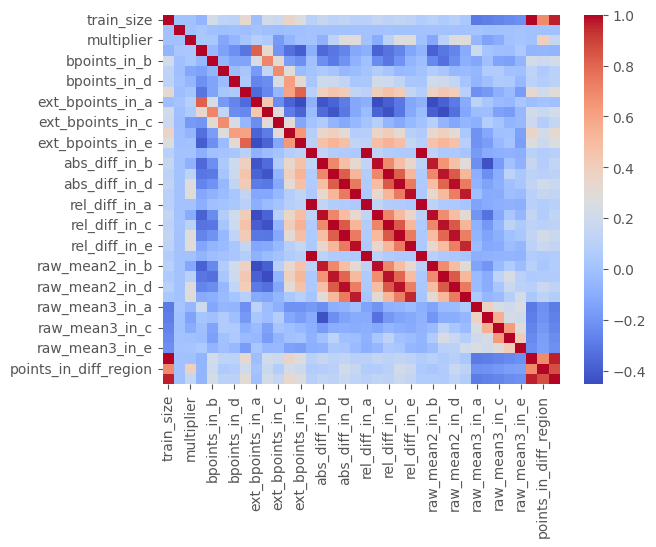

In [75]:
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")

In [76]:
df.columns

Index(['train_size', 'random_seed', 'multiplier', 'region', 'bpoints_in_a',
       'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
       'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c',
       'ext_bpoints_in_d', 'ext_bpoints_in_e', 'abs_diff_in_a',
       'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
       'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d',
       'rel_diff_in_e', 'raw_mean2_in_a', 'raw_mean2_in_b', 'raw_mean2_in_c',
       'raw_mean2_in_d', 'raw_mean2_in_e', 'raw_mean3_in_a', 'raw_mean3_in_b',
       'raw_mean3_in_c', 'raw_mean3_in_d', 'raw_mean3_in_e',
       'points_in_equal_regions', 'points_in_diff_region', 'total_points'],
      dtype='object')

### uurime miks on 50 suuruse puhul asjad væga katki

In [77]:
df[(df["train_size"]==50)&(df["multiplier"]==0.5)&(df["region"]=='A')]

train_size  random_seed  multiplier region  bpoints_in_a  bpoints_in_b  \
5050          50            0         0.5      A             5             3   
5051          50            1         0.5      A             6             2   
5052          50            2         0.5      A            10             4   
5053          50            3         0.5      A             7             2   
5054          50            4         0.5      A             7             2   
5055          50            5         0.5      A            10             1   
5056          50            6         0.5      A             5             6   
5057          50            7         0.5      A             4             1   
5058          50            8         0.5      A             7             2   
5059          50            9         0.5      A             7             2   
5060          50           10         0.5      A             6             6   
5061          50           11         0.5      A             8             0   
5062          50           12         0.5      A            11             1   
5063          50           13         0.5      A             6             1   
5064          50           14         0.5      A             6             4   
5065          50           15         0.5      A             8             2   
5066          50           16         0.5      A            12             4   
5067          50           17         0.5      A             8             1   
5068          50           18         0.5      A             9             0   
5069          50           19         0.5      A            10             1   
5070          50           20         0.5      A            10             0   
5071          50           21         0.5      A             8             0   
5072          50           22         0.5      A            13             2   
5073          50           23         0.5      A             5             4   
5074          50           24         0.5      A             8             6   
5075          50           25         0.5      A            14             1   
5076          50           26         0.5      A            16             1   
5077          50           27         0.5      A            11             1   
5078          50           28         0.5      A            10             0   
5079          50           29         0.5      A             8             2   
5080          50           30         0.5      A            16             0   
5081          50           31         0.5      A            10             1   
5082          50           32         0.5      A             6             3   
5083          50           33         0.5      A             9             0   
5084          50           34         0.5      A             9             2   
5085          50           35         0.5      A            13             1   
5086          50           36         0.5      A            11             2   
5087          50           37         0.5      A             8             2   
5088          50           38         0.5      A             2             2   
5089          50           39         0.5      A            12             5   
5090          50           40         0.5      A            10             3   
5091          50           41         0.5      A             4             6   
5092          50           42         0.5      A             9             3   
5093          50           43         0.5      A             8             6   
5094          50           44         0.5      A            14             0   
5095          50           45         0.5      A             7             6   
5096          50           46         0.5      A            12             4   
5097          50           47         0.5      A             7             4   
5098          50           48         0.5      A            11             0   
5099  

In [78]:
df.drop(4918, inplace=True)

In [79]:
df[df["abs_diff_in_a"] > 2.5]

train_size  random_seed  multiplier region  bpoints_in_a  bpoints_in_b  \
474           10           24        4.00      B             5             5   
2524          30           24        0.25      A             5             5   
2750          30            0        0.25      B             5             0   
5002          50            2        0.25      A             4             8   
5007          50            7        0.25      A             9             4   
5085          50           35        0.50      A            13             1   
5786          50           36        0.25      D            12             5   

      bpoints_in_c  bpoints_in_d  bpoints_in_e  ext_bpoints_in_a  \
474              1             1             0                11   
2524             0             1             3                13   
2750             0             2             2                 7   
5002             1             2             0                 7   
5007             2             1             0                13   
5085             0             0             1                16   
5786             1             0             0                19   

      ext_bpoints_in_b  ext_bpoints_in_c  ext_bpoints_in_d  ext_bpoints_in_e  \
474                  9                 4                 1                 1   
2524                 6                 3                 4                 4   
2750                 4                 1                 3                 5   
5002                 9                 8                 2                 2   
5007                 7                 7                 2                 0   
5085                 5                 0                 1                 1   
5786                12                 3                 0                 0   

      abs_diff_in_a  abs_diff_in_b  abs_diff_in_c  abs_diff_in_d  \
474        4.597854      -2.003821      -1.367182      -0.638173   
2524       4.476680       0.944672       0.585830       0.631503   
2750       2.788395      -0.309594       0.532219       0.945060   
5002       3.570483      -0.409800      -0.530874       0.081469   
5007       3.113132       0.006331      -0.163262       0.003444   
5085     460.134419      -0.540530      -0.158810       0.184324   
5786       3.367089      -1.262599      -0.485807      -0.176945   

      abs_diff_in_e  rel_diff_in_a  rel_diff_in_b  rel_diff_in_c  \
474       -0.289457       1.289667      -0.835740      -0.879731   
2524       0.531419       1.203711       0.417674       0.395734   
2750       0.072179       0.804643      -0.148008       0.353445   
5002       0.145473       1.029151      -0.176264      -0.341848   
5007       0.198749       1.035885       0.002911      -0.106659   
5085       0.523914     137.428014      -0.246732      -0.104098   
5786       0.152623       0.887609      -0.592131      -0.310140   

      rel_diff_in_d  rel_diff_in_e  raw_mean2_in_a  raw_mean2_in_b  \
474       -0.555008      -0.302866        8.163003        0.393839   
2524       0.634292       0.813286        8.195746        3.206415   
2750       0.943486       0.119192        6.253778        1.782138   
5002       0.083825       0.291638        7.039830        1.915124   
5007       0.003473       0.374499        6.118419        2.181676   
5085       0.195123       1.160353      463.482604        1.650231   
5786      -0.176892       0.321223        7.160527        0.869698   

      raw_mean2_in_c  raw_mean2_in_d  raw_mean2_in_e  raw_mean3_in_a  \
474         0.186909        0.511672        0.666268        3.565149   
2524        2.066192        1.627106        1.184842        3.719066   
2750        2.038025        1.946727        0.677751        3.465383   
5002        1.022079        1.053359        0.644285        3.469347   
5007        1.367430        0.995172        0.729455        3.005287   
5085        1.366776        1.128977        0.975426        3.348185   
5786        1.080606    

## Joonistame!

### train_size, total_points, multiplier, region, points_in_equal_regions, points_in_diff_region

### bpoints_in, ext_bpoints_in, abs_diff_in, rel_diff_in, raw_mean2, raw_mean3

In [80]:
# OLULINE: BACKUP ONLY
big_df = df.copy()
# võtame keskmise üle meie kolme suure parameetri (keskmistame random seedid välja pmst)
# df = df.groupby(['region', 'multiplier', 'train_size']).mean().reset_index()

In [81]:
df = big_df.groupby(['region', 'multiplier', 'train_size']).mean().reset_index()

In [82]:
df.head()

region  multiplier  train_size  random_seed  bpoints_in_a  bpoints_in_b  \
0      A        0.25          10         24.5          8.10          4.08   
1      A        0.25          20         24.5          4.30          3.52   
2      A        0.25          30         24.5          3.08          2.98   
3      A        0.25          40         24.5          6.44          3.72   
4      A        0.25          50         24.5          5.84          2.76   

   bpoints_in_c  bpoints_in_d  bpoints_in_e  ext_bpoints_in_a  \
0          3.32          1.42          1.04             14.00   
1          1.22          0.74          0.22              9.16   
2          2.20          2.72          1.18              7.08   
3          1.02          0.88          1.12             11.98   
4          1.40          1.50          0.44             10.06   

   ext_bpoints_in_b  ext_bpoints_in_c  ext_bpoints_in_d  ext_bpoints_in_e  \
0              9.72              5.70              3.24              2.22   
1              5.06              3.00              1.74              0.92   
2              4.98              4.54              4.66              3.64   
3              6.46              2.88              1.96              2.30   
4              5.92              3.74              2.38              1.62   

   abs_diff_in_a  abs_diff_in_b  abs_diff_in_c  abs_diff_in_d  abs_diff_in_e  \
0      -2.810487      -1.756388      -0.643656      -0.471517      -0.361941   
1      -1.697460       0.819885       0.884066       0.169232       0.020457   
2      -0.624586       0.226472       0.750130       0.406113       0.296198   
3      -1.880686       0.904934       0.073984      -0.255699      -0.201096   
4      -0.851474      -0.733362      -0.415959      -0.034979       0.173283   

   rel_diff_in_a  rel_diff_in_b  rel_diff_in_c  rel_diff_in_d  rel_diff_in_e  \
0      -0.952812      -0.767653      -0.296365      -0.364753      -0.558796   
1      -0.620875       0.387386       0.554664       0.166814       0.042651   
2      -0.140133       0.118976       0.493325       0.380637       0.423948   
3      -0.682882       0.423594       0.049395      -0.250053      -0.318447   
4      -0.105141      -0.297561      -0.262628      -0.036210       0.333789   

   raw_mean2_in_a  raw_mean2_in_b  raw_mean2_in_c  raw_mean2_in_d  \
0        0.133848        0.561893        1.418766        0.853976   
1        1.040654        2.958840        2.486166        1.216919   
2        2.638199        2.557501        2.294671        1.513639   
3        0.874606        3.050828        1.618564        0.765899   
4        2.838550        1.685754        1.156696        0.938037   

   raw_mean2_in_e  raw_mean3_in_a  raw_mean3_in_b  raw_mean3_in_c  \
0        0.326068        2.944335        2.318282        2.062422   
1        0.521457        2.738114        2.138955        1.602100   
2        1.041025        3.262785        2.331029        1.544541   
3        0.423386        2.755293        2.145895        1.544579   
4        0.716931        3.690024        2.419116        1.572655   

   raw_mean3_in_d  raw_mean3_in_e  points_in_equal_regions  \
0        1.325493        0.688008                      2.0   
1        1.047688        0.501000                      4.0   
2        1.107526        0.744827                      6.0   
3        1.021598        0.624482                      8.0   
4        0.973016        0.543648                     10.0   

   points_in_diff_region  total_points  
0                    0.0           8.0  
1                    1.0          17.0  
2                    1.0          25.0  
3                    2.0          34.0  
4                    2.0          42.0

<AxesSubplot: xlabel='total_points', ylabel='Count'>

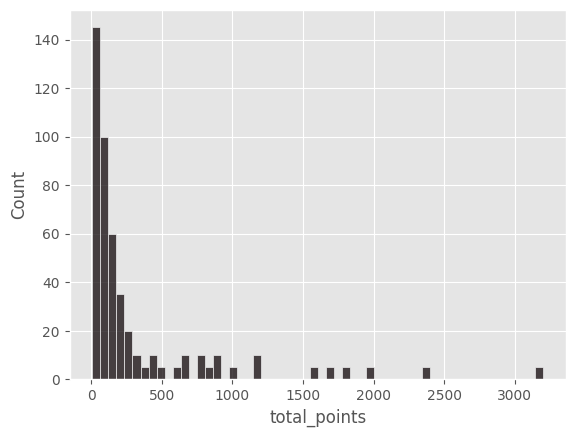

In [83]:
sns.histplot(data=df, x ="total_points",)

In [92]:
df = df[df["abs_diff_in_a"]<5]


<AxesSubplot: xlabel='abs_diff_in_a', ylabel='raw_mean3_in_a'>

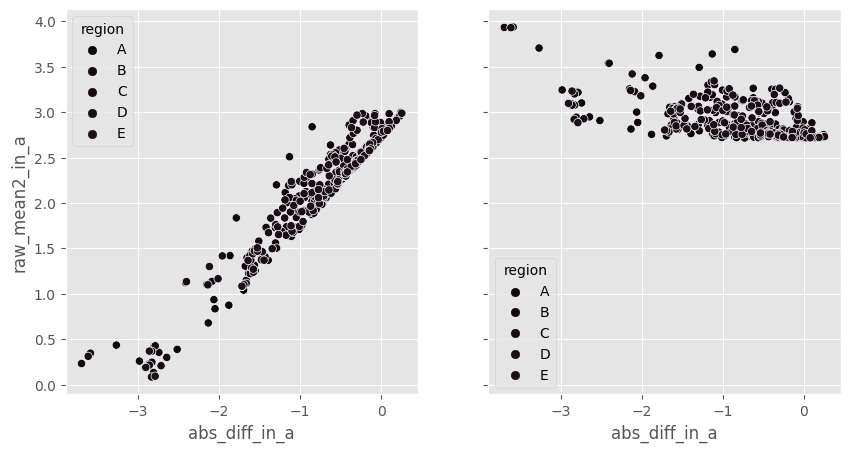

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
x = 10
sns.scatterplot(ax=ax[0], data=df, x="abs_diff_in_a",y="raw_mean2_in_a", hue="region",) #size="multiplier", sizes=(1*x, 5*x))
sns.scatterplot(ax=ax[1], data=df, x="abs_diff_in_a",y="raw_mean3_in_a", hue="region", )#size="multiplier", sizes=(1*x, 5*x))

Text(0.5, 1.0, 'Kui muudatused on ainult A piirkonnas, kuidas siis muutuvad abs ja rel teistes piirkondades')

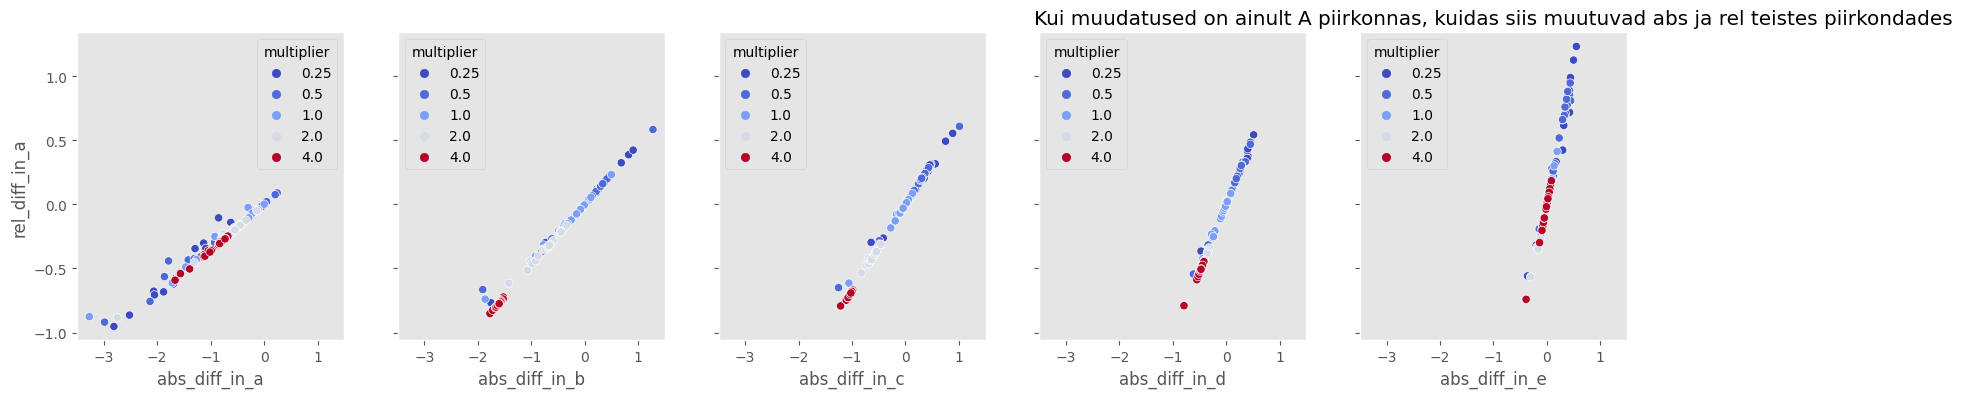

In [102]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

sns.scatterplot(ax=ax[0], data=df[df['region'] == 'A'], x="abs_diff_in_a", y="rel_diff_in_a", hue="multiplier", palette="coolwarm")
sns.scatterplot(ax=ax[1], data=df[df['region'] == 'A'], x="abs_diff_in_b", y="rel_diff_in_b", hue="multiplier", palette="coolwarm")
sns.scatterplot(ax=ax[2], data=df[df['region'] == 'A'], x="abs_diff_in_c", y="rel_diff_in_c", hue="multiplier", palette="coolwarm")
sns.scatterplot(ax=ax[3], data=df[df['region'] == 'A'], x="abs_diff_in_d", y="rel_diff_in_d", hue="multiplier", palette="coolwarm")
sns.scatterplot(ax=ax[4], data=df[df['region'] == 'A'], x="abs_diff_in_e", y="rel_diff_in_e", hue="multiplier", palette="coolwarm")
[a.grid() for a in ax]
plt.title("Kui muudatused on ainult A piirkonnas, kuidas siis muutuvad abs ja rel teistes piirkondades")

In [ ]:
sns.set_palette("viridis")
plt.style.use('ggplot')
plt.rcParams["image.cmap"] = "viridis"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, 5)))

<AxesSubplot: xlabel='abs_diff_in_e', ylabel='points_in_equal_regions'>

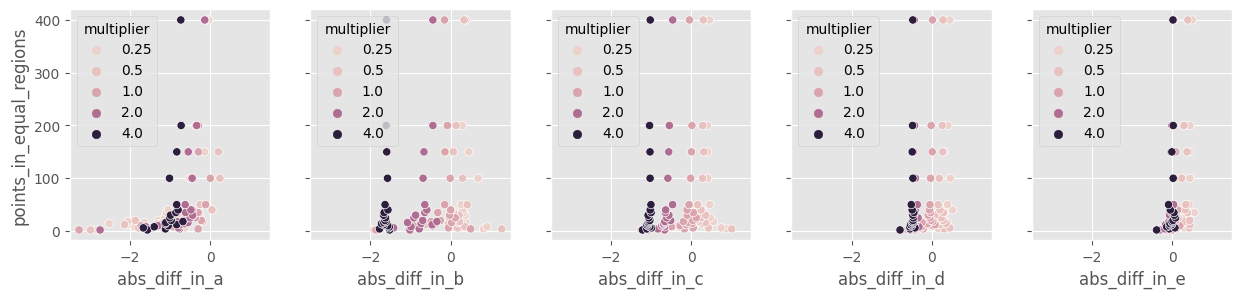

In [103]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)

# ax[0].set_xscale("log")

sns.scatterplot(ax=ax[0], data=df[df['region'] == 'A'], x="abs_diff_in_a", y="points_in_equal_regions", hue="multiplier", )
sns.scatterplot(ax=ax[1], data=df[df['region'] == 'A'], x="abs_diff_in_b", y="points_in_equal_regions", hue="multiplier", )
sns.scatterplot(ax=ax[2], data=df[df['region'] == 'A'], x="abs_diff_in_c", y="points_in_equal_regions", hue="multiplier", )
sns.scatterplot(ax=ax[3], data=df[df['region'] == 'A'], x="abs_diff_in_d", y="points_in_equal_regions", hue="multiplier", )
sns.scatterplot(ax=ax[4], data=df[df['region'] == 'A'], x="abs_diff_in_e", y="points_in_equal_regions", hue="multiplier", )
#plt.title("Kui muudatused on ainult A piirkonnas, kuidas siis muutuvad abs ja rel teistes piirkondades")

In [104]:
df["total_points"].nunique()

81

In [ ]:
diverging_colors = sns.color_palette("mako", df["total_points"].nunique())
sns.set_palette(diverging_colors)
plt.show()

C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\1976325012.py:18: UserWarning: The palette list has more values (81) than needed (80), which may not be intended.
  sns.scatterplot(ax=ax[i, j], data=df[df['region'] == chr(65+i)], x=x, y=y, hue=hue, palette=diverging_colors)
C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\1976325012.py:18: UserWarning: The palette list has more values (81) than needed (80), which may not be intended.
  sns.scatterplot(ax=ax[i, j], data=df[df['region'] == chr(65+i)], x=x, y=y, hue=hue, palette=diverging_colors)
C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\1976325012.py:18: UserWarning: The palette list has more values (81) than needed (80), which may not be intended.
  sns.scatterplot(ax=ax[i, j], data=df[df['region'] == chr(65+i)], x=x, y=y, hue=hue, palette=diverging_colors)
C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\1976325012.py:18: UserWarning: The palette list has more values (81) than needed (80), which may not be intended.


legend
title
save


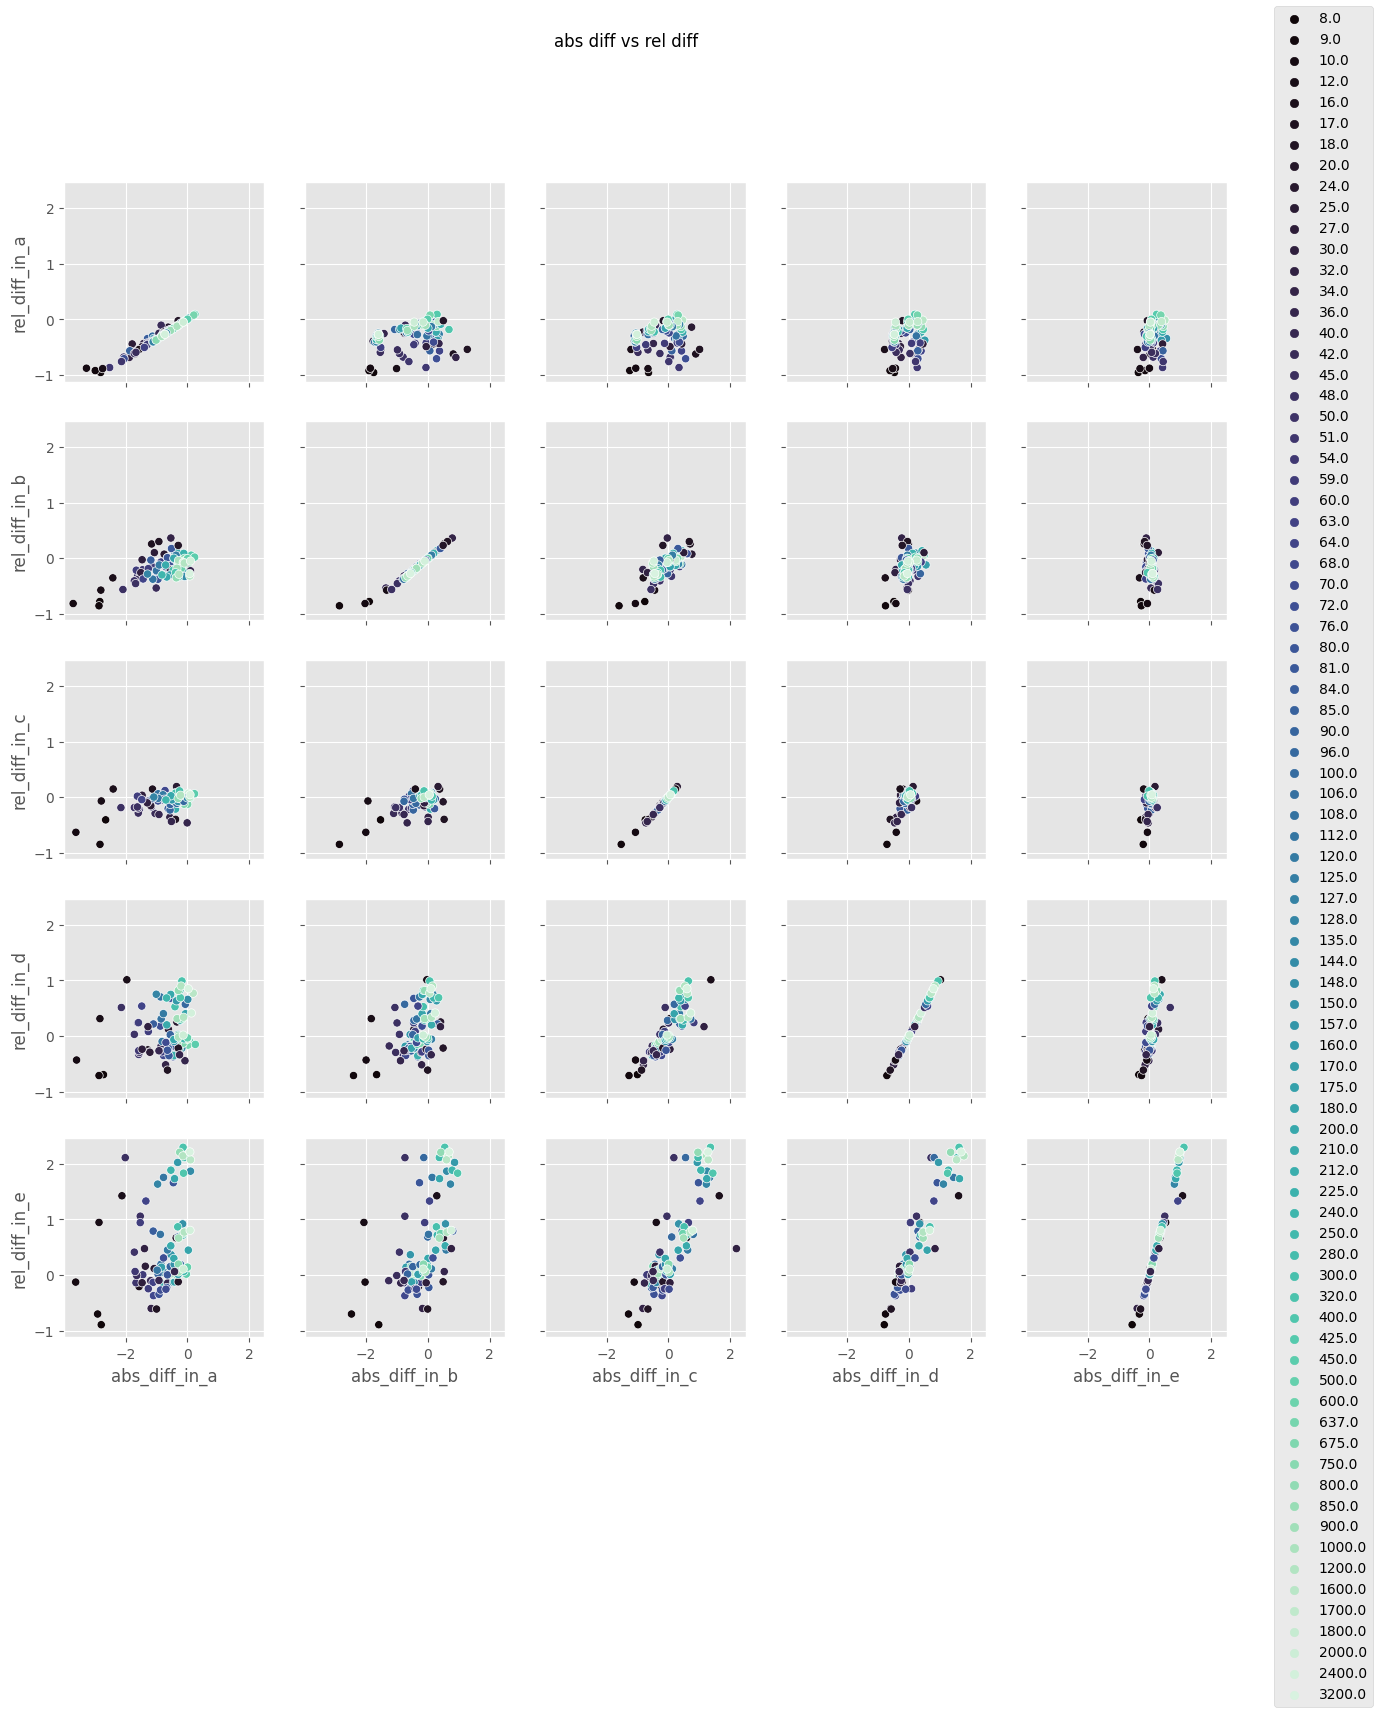

In [105]:
def megaplotty(x_axis_data,x_letter, y_axis_data, y_letter, df, hue='multiplier', title="", save=False):

    fig, ax = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)

    # ax[0].set_xscale("log")
    diverging_colors = sns.color_palette("mako", df[hue].nunique())
    for i in range(5):
        for j in range(5):
            if x_letter:
                x = x_axis_data+chr(97+j)
            else:
                x = x_axis_data
            if y_letter:
                y = y_axis_data+chr(97+i)
            else:
                y = y_axis_data
            #print(f"Subplot {i}, {j} saab endale {x} ja {y}, koos region {chr(65+i)}")
            sns.scatterplot(ax=ax[i, j], data=df[df['region'] == chr(65+i)], x=x, y=y, hue=hue, palette=diverging_colors)
            #ax[i, j].set_title(f"abs_diff_in_{chr(97+i)}")
            ax[i,j]
            handles, labels = ax[i,j].get_legend_handles_labels() # võtab legendi ja salvestab ära, tegelikult võib ka lõpus korra teha seda
            ax[i,j].get_legend().remove()   # et iga subplot ei kuvaks sama legendi
    print("legend")
    fig.legend(handles, labels, loc='upper right')
    #plt.legend()

    print("title")
    plt.suptitle(title)

    print("save")
    if save:
        plt.savefig(f"plots/ilusad/{title}.jpeg", dpi=100)

megaplotty('abs_diff_in_',True, 'rel_diff_in_',True ,df, hue='total_points', title="abs diff vs rel diff", save=True)

KeyboardInterrupt: 

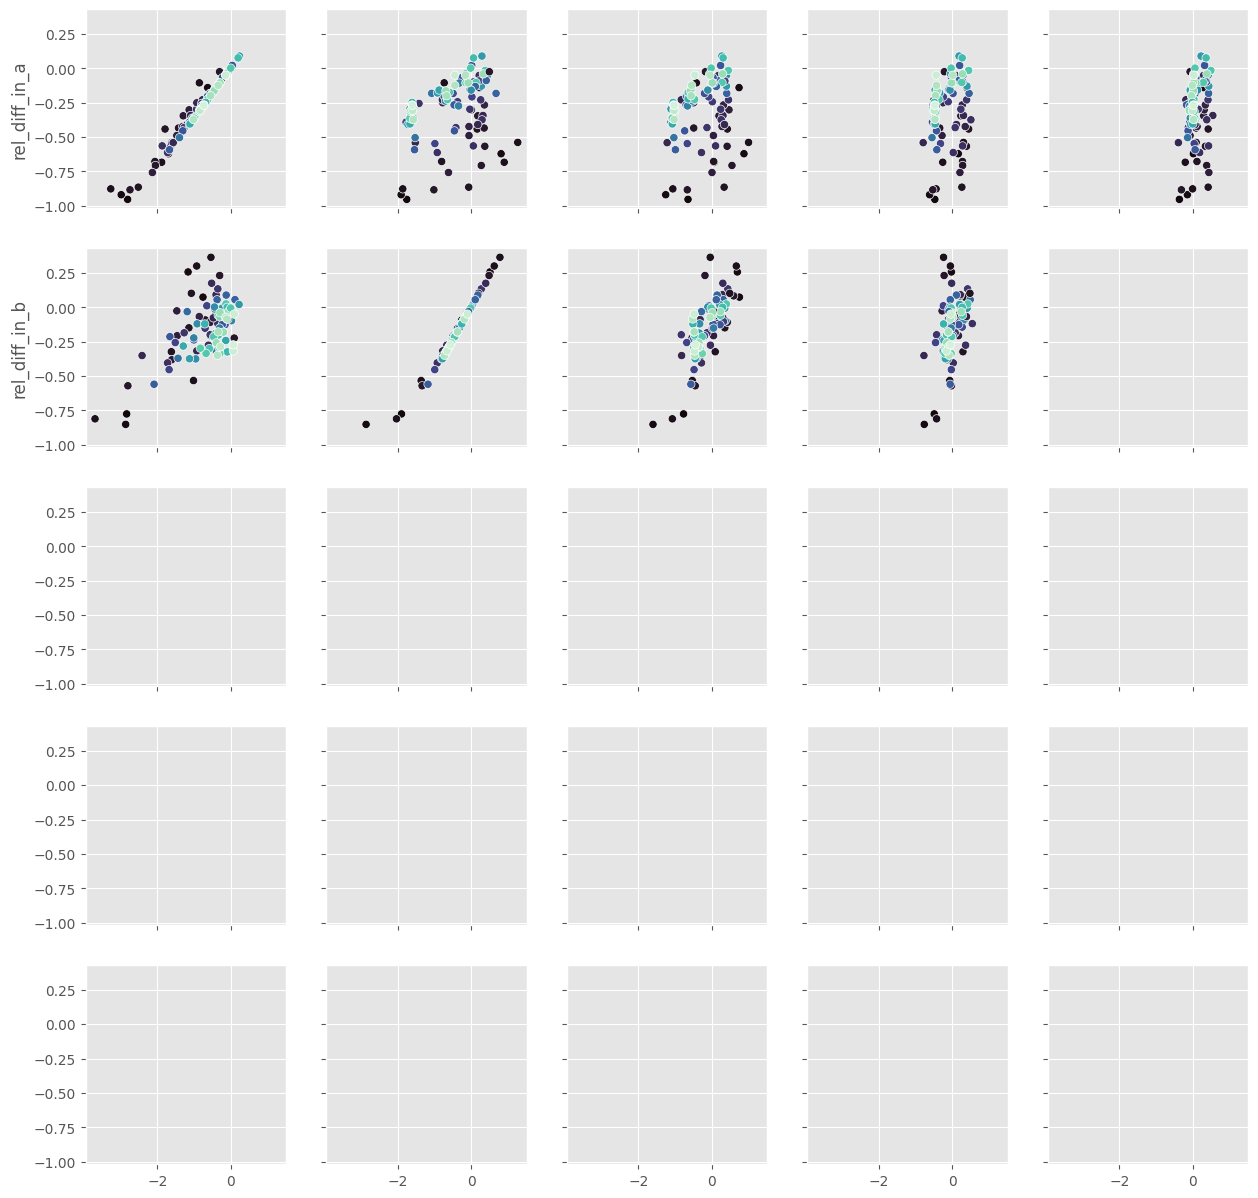

In [100]:
megaplotty('abs_diff_in_',True, 'rel_diff_in_',True ,df, hue='points_in_diff_region', title="abs diff vs rel diff", save=True)

In [ ]:
# megaplotty('total_points',False, 'rel_diff_in_',True ,df, hue='multiplier', title="total points vs relative diff", save=True)
# megaplotty('points_in_equal_regions',False, 'rel_diff_in_',True ,df, hue='multiplier', title="num equal points vs relative diff", save=True)
# megaplotty('points_in_diff_region',False, 'rel_diff_in_',True ,df, hue='multiplier', title="num diff points vs relative diff", save=True)

In [ ]:
# megaplotty('total_points',False, 'abs_diff_in_',True ,df, hue='multiplier', title="total points vs absolute diff", save=True)
# megaplotty('points_in_equal_regions',False, 'abs_diff_in_',True ,df, hue='multiplier', title="num equal points vs absolute diff", save=True)
# megaplotty('points_in_diff_region',False, 'abs_diff_in_',True ,df, hue='multiplier', title="num diff points vs absolute diff", save=True)

legend
title
save


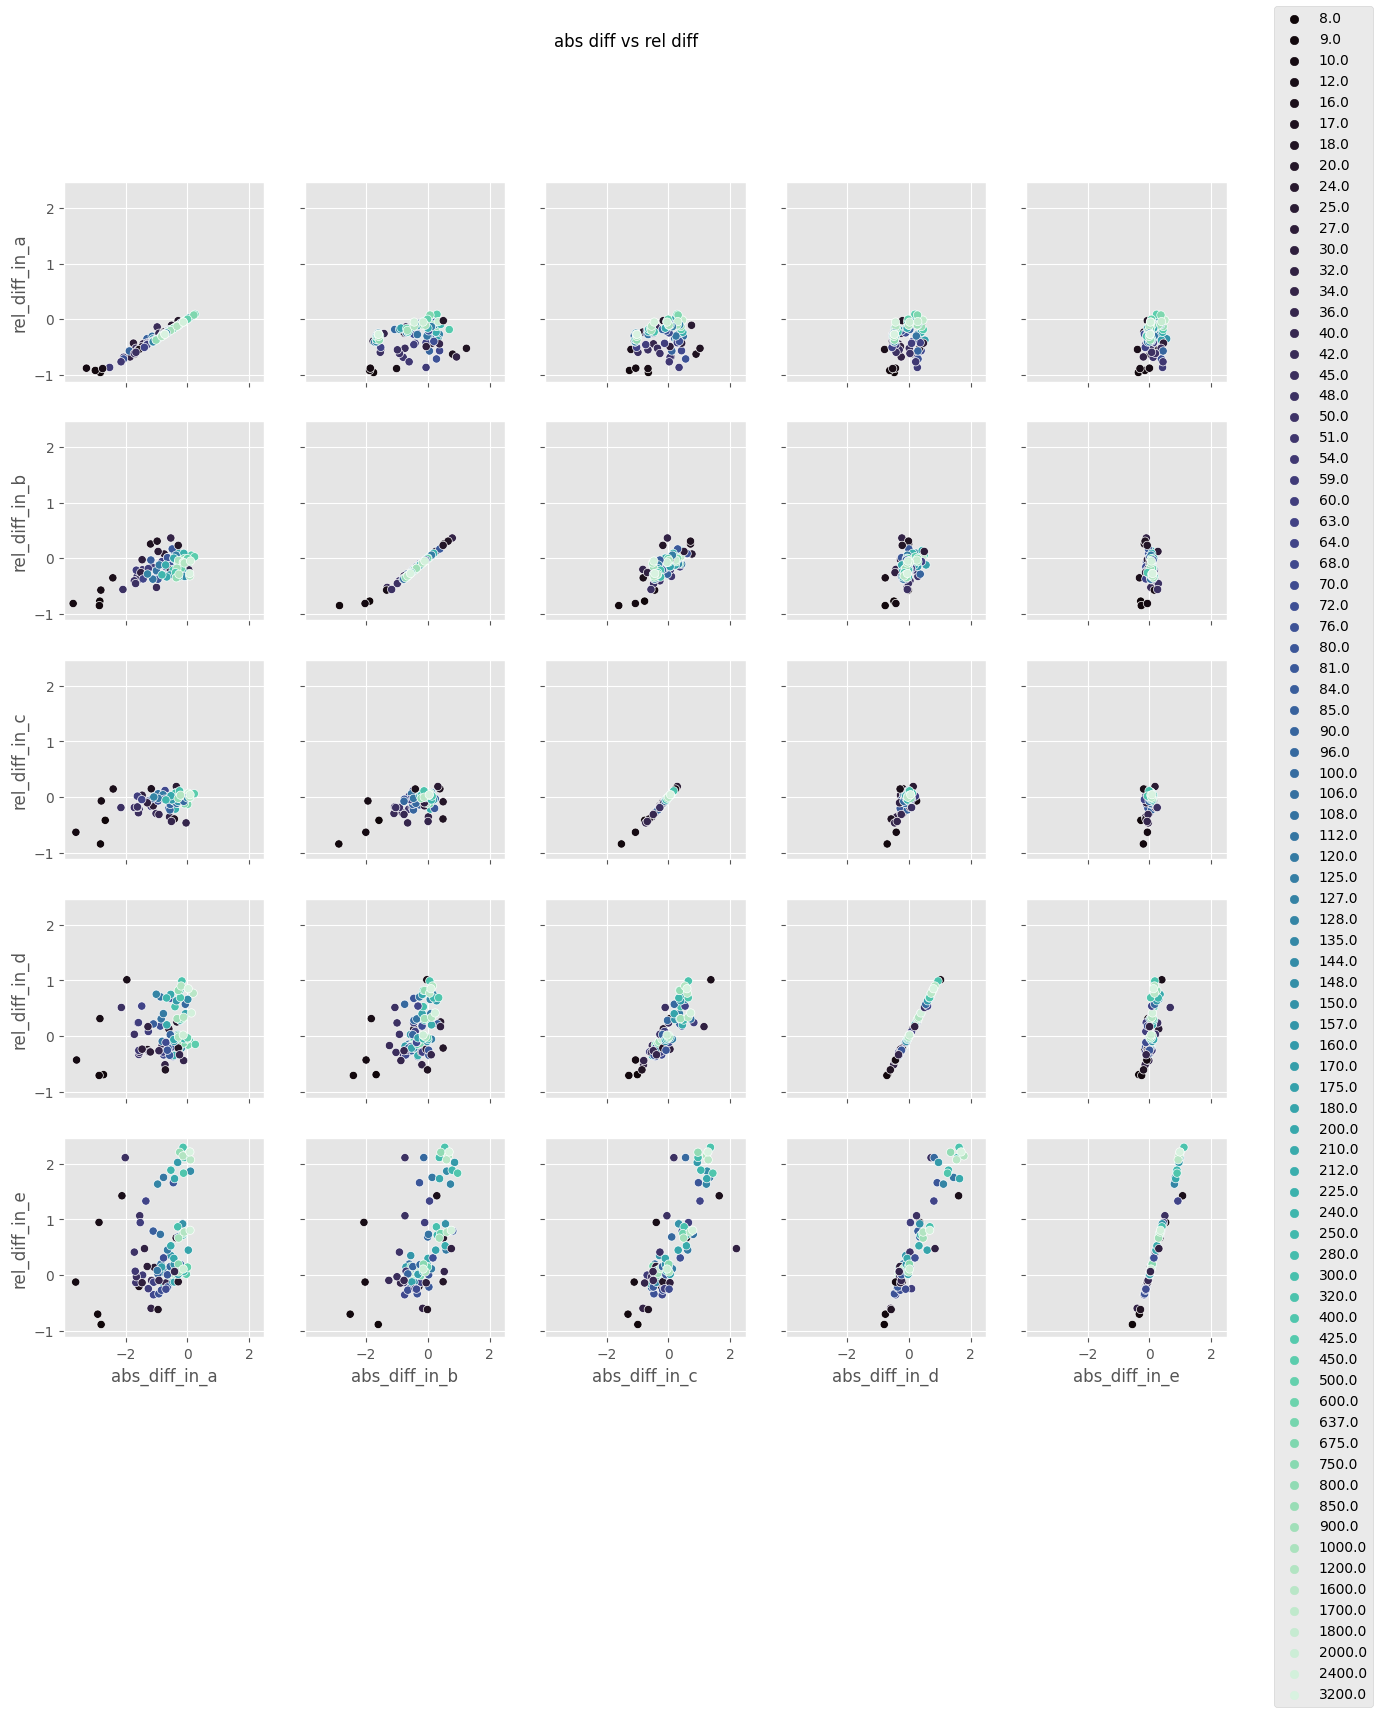

In [ ]:
megaplotty('abs_diff_in_',True, 'rel_diff_in_',True ,df, hue='total_points', title="abs diff vs rel diff", save=True)

legend
title
save


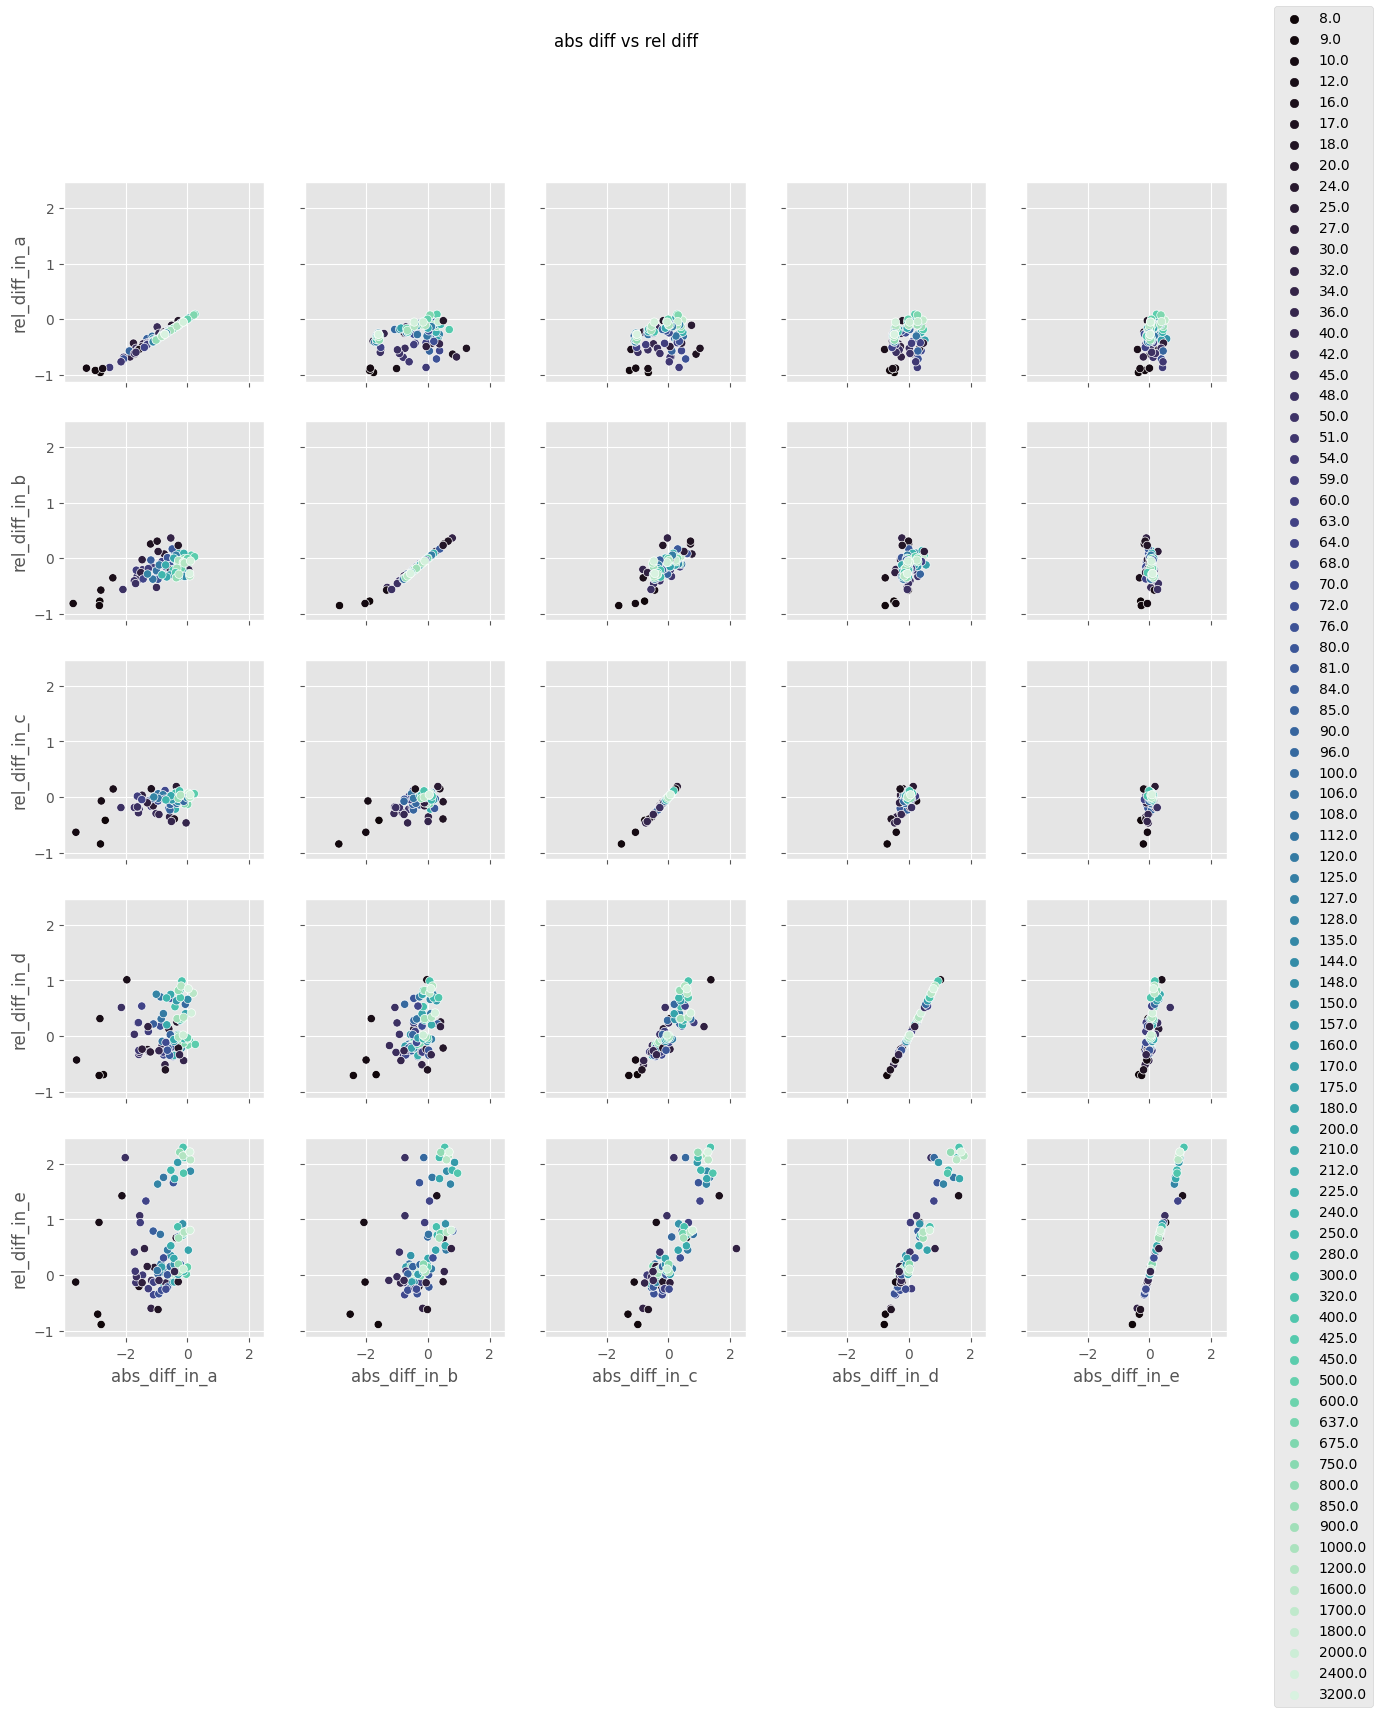

In [ ]:
megaplotty('abs_diff_in_',True, 'rel_diff_in_',True ,df, hue='total_points', title="abs diff vs rel diff", save=True)
# megaplotty('ext_bpoints_in_',True, 'rel_diff_in_',True ,df, hue='multiplier', title="extended bpoints vs relative diff", save=True)

legend
title
save
legend
title
save


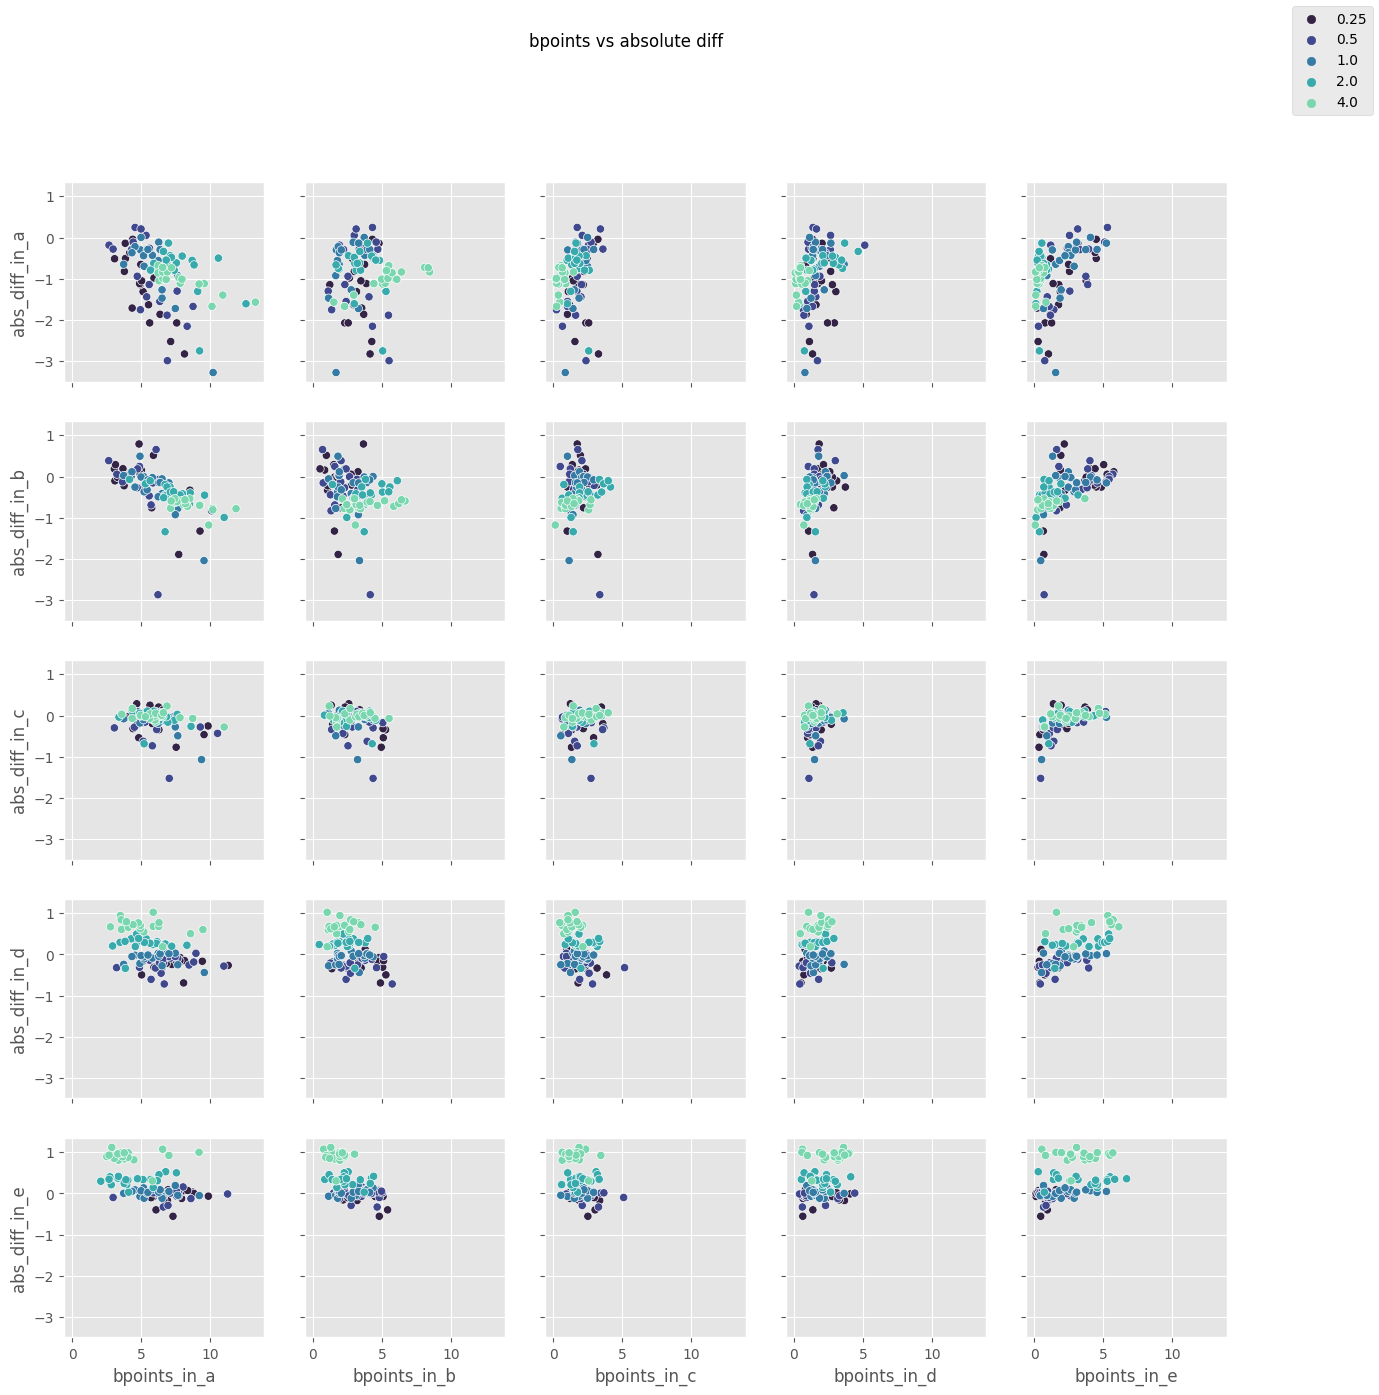

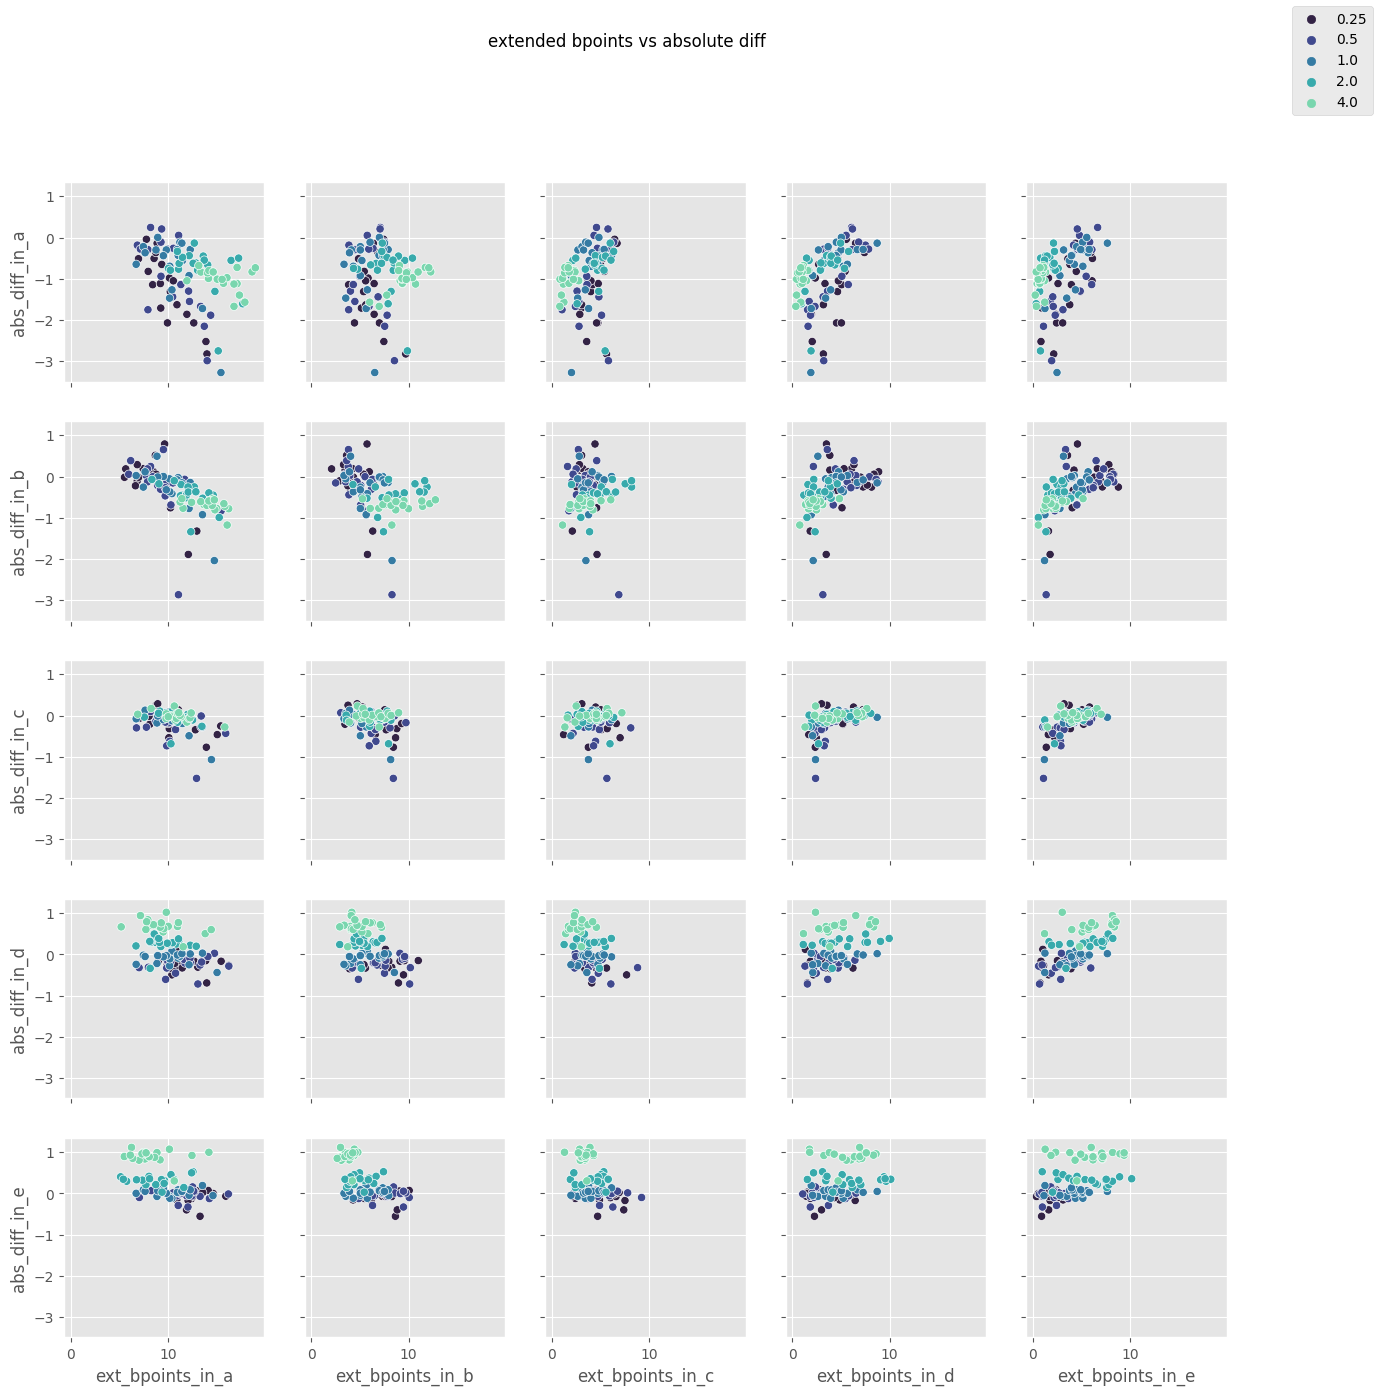

In [ ]:
megaplotty('bpoints_in_',True, 'abs_diff_in_',True ,df, hue='multiplier', title="bpoints vs absolute diff", save=True)
megaplotty('ext_bpoints_in_',True, 'abs_diff_in_',True ,df, hue='multiplier', title="extended bpoints vs absolute diff", save=True)

In [ ]:
df.to_excel("andmed\\uneven_all_avgs.xlsx")

In [ ]:
pd.set_option('display.max_columns', 40)
df[df["abs_diff_in_a"]>5]

Empty DataFrame
Columns: [region, multiplier, train_size, random_seed, bpoints_in_a, bpoints_in_b, bpoints_in_c, bpoints_in_d, bpoints_in_e, ext_bpoints_in_a, ext_bpoints_in_b, ext_bpoints_in_c, ext_bpoints_in_d, ext_bpoints_in_e, abs_diff_in_a, abs_diff_in_b, abs_diff_in_c, abs_diff_in_d, abs_diff_in_e, rel_diff_in_a, rel_diff_in_b, rel_diff_in_c, rel_diff_in_d, rel_diff_in_e, raw_mean2_in_a, raw_mean2_in_b, raw_mean2_in_c, raw_mean2_in_d, raw_mean2_in_e, raw_mean3_in_a, raw_mean3_in_b, raw_mean3_in_c, raw_mean3_in_d, raw_mean3_in_e, points_in_equal_regions, points_in_diff_region, total_points]
Index: []

In [ ]:
df.columns

Index(['region', 'multiplier', 'train_size', 'random_seed', 'bpoints_in_a',
       'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
       'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c',
       'ext_bpoints_in_d', 'ext_bpoints_in_e', 'abs_diff_in_a',
       'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
       'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d',
       'rel_diff_in_e', 'raw_mean2_in_a', 'raw_mean2_in_b', 'raw_mean2_in_c',
       'raw_mean2_in_d', 'raw_mean2_in_e', 'raw_mean3_in_a', 'raw_mean3_in_b',
       'raw_mean3_in_c', 'raw_mean3_in_d', 'raw_mean3_in_e',
       'points_in_equal_regions', 'points_in_diff_region', 'total_points'],
      dtype='object')

In [107]:
df["combo_name"] = df["train_size"].astype(str) + "_" + df["region"] + "_" + df["multiplier"].astype(str)

In [ ]:
lil_df = df[['region', 'multiplier', 'train_size', 'abs_diff_in_a', 'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e', 'total_points']]

In [ ]:
lil_df.head()
lil_df["combo_name"] = lil_df["train_size"].astype(str) + "_" + lil_df["region"] + "_" + lil_df["multiplier"].astype(str)
lil_df.head()

C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\4055688904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lil_df["combo_name"] = lil_df["train_size"].astype(str) + "_" + lil_df["region"] + "_" + lil_df["multiplier"].astype(str)


region  multiplier  train_size  abs_diff_in_a  abs_diff_in_b  abs_diff_in_c  \
0      A        0.25          10      -2.819547      -1.760115      -0.651220   
1      A        0.25          20      -1.707891       0.799361       0.893915   
2      A        0.25          30      -0.512846       0.258066       0.747456   
3      A        0.25          40      -1.859237       0.926484       0.083881   
4      A        0.25          50      -0.979437      -0.717868      -0.395567   

   abs_diff_in_d  abs_diff_in_e  total_points combo_name  
0      -0.475795      -0.359955           8.0  10_A_0.25  
1       0.174593       0.021304          17.0  20_A_0.25  
2       0.412443       0.297480          25.0  30_A_0.25  
3      -0.251058      -0.198804          34.0  40_A_0.25  
4      -0.033100       0.172591          42.0  50_A_0.25

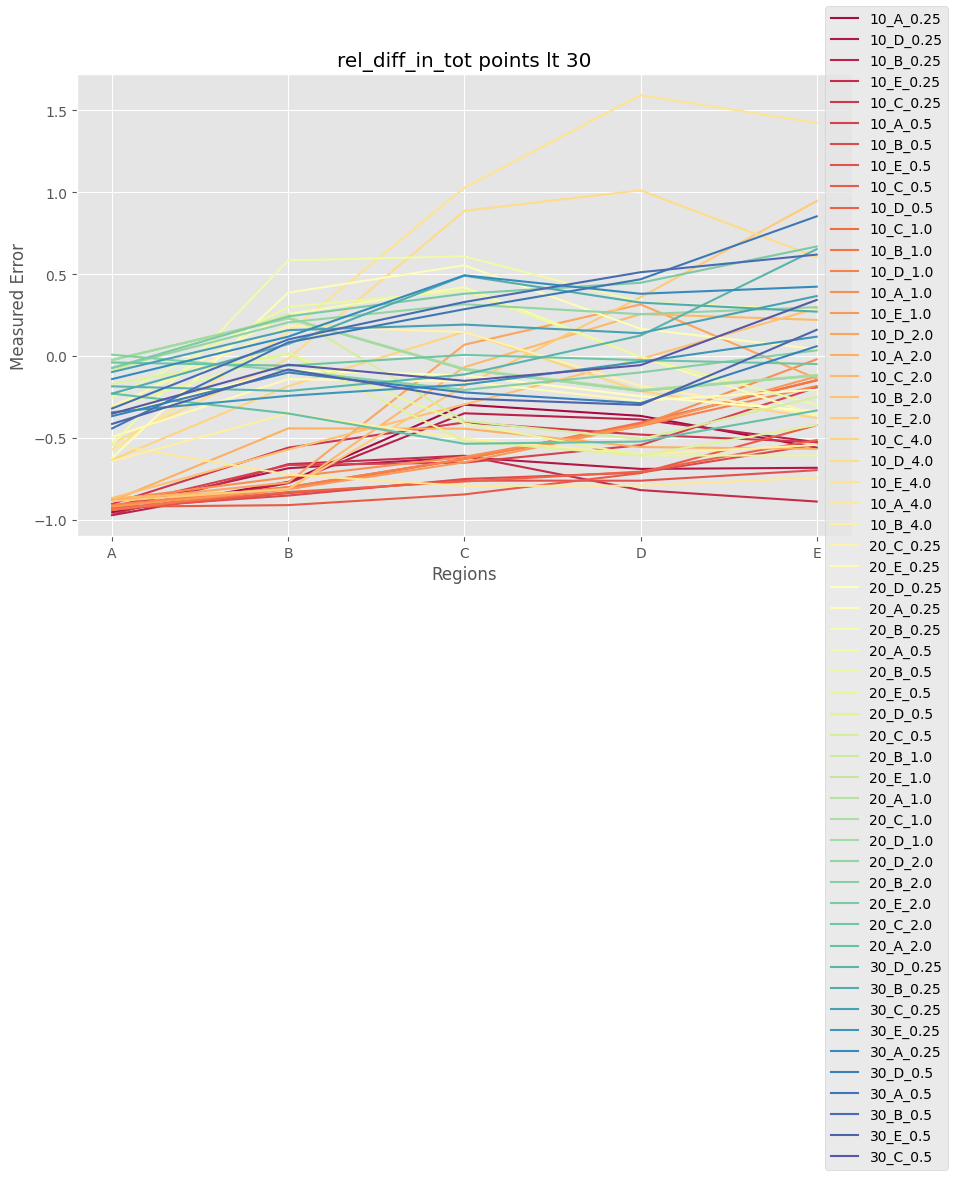

In [108]:
def plotter_2(df, x,title_additional=""):
    regions = ['A', 'B', 'C', 'D', 'E']

    fig, ax = plt.subplots(figsize=(10, 6))
    
    diverging_colors = sns.color_palette("Spectral", df.shape[0])
    # sns.palplot(diverging_colors)

    for i, values in enumerate(df.iterrows()):
        ax.plot(regions, values[1][[*[f"{x}{chr(i+97)}" for i in range(5)]]], label=values[1]["combo_name"], color=diverging_colors[i])
        
        handles, labels = ax.get_legend_handles_labels()

    ax.set_xlabel('Regions')
    ax.set_ylabel('Measured Error')
    ax.set_title(x+title_additional)
    # ax.legend()
    
    fig.legend(handles, labels, loc='upper right')
    
    plt.show()
    fig.savefig(f"plots/ilusad/normal_lot_of_data/regions_and_{x}_{title_additional}.jpeg", dpi=300)

test_df = df[df["total_points"]<30].sort_values("total_points")
plotter_2(test_df, "rel_diff_in_", "tot points lt 30")

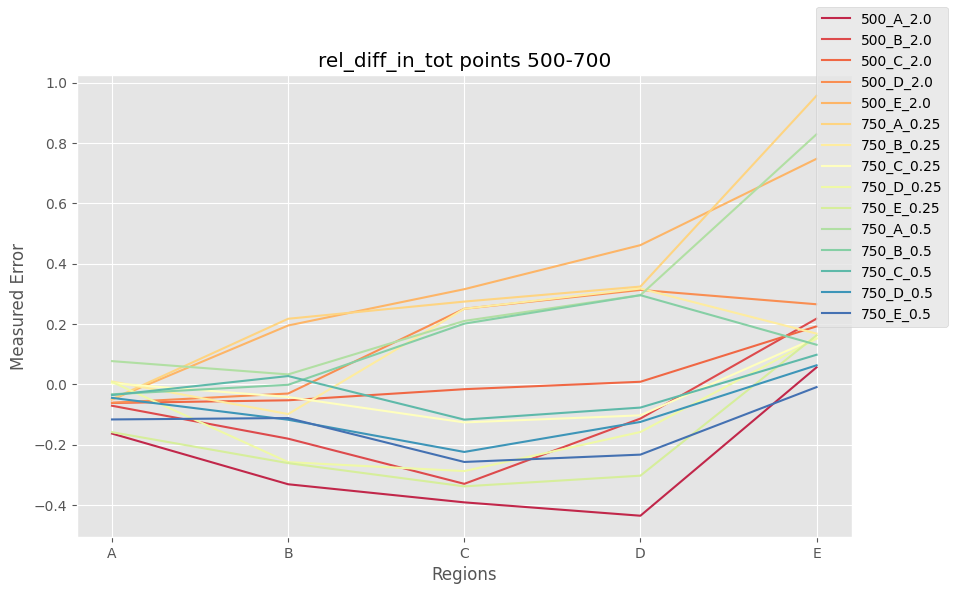

In [ ]:
test_df = df[(df["total_points"]>500)&(df["total_points"]<700)].sort_values("total_points")
plotter_2(test_df, "rel_diff_in_", "tot points 500-700")

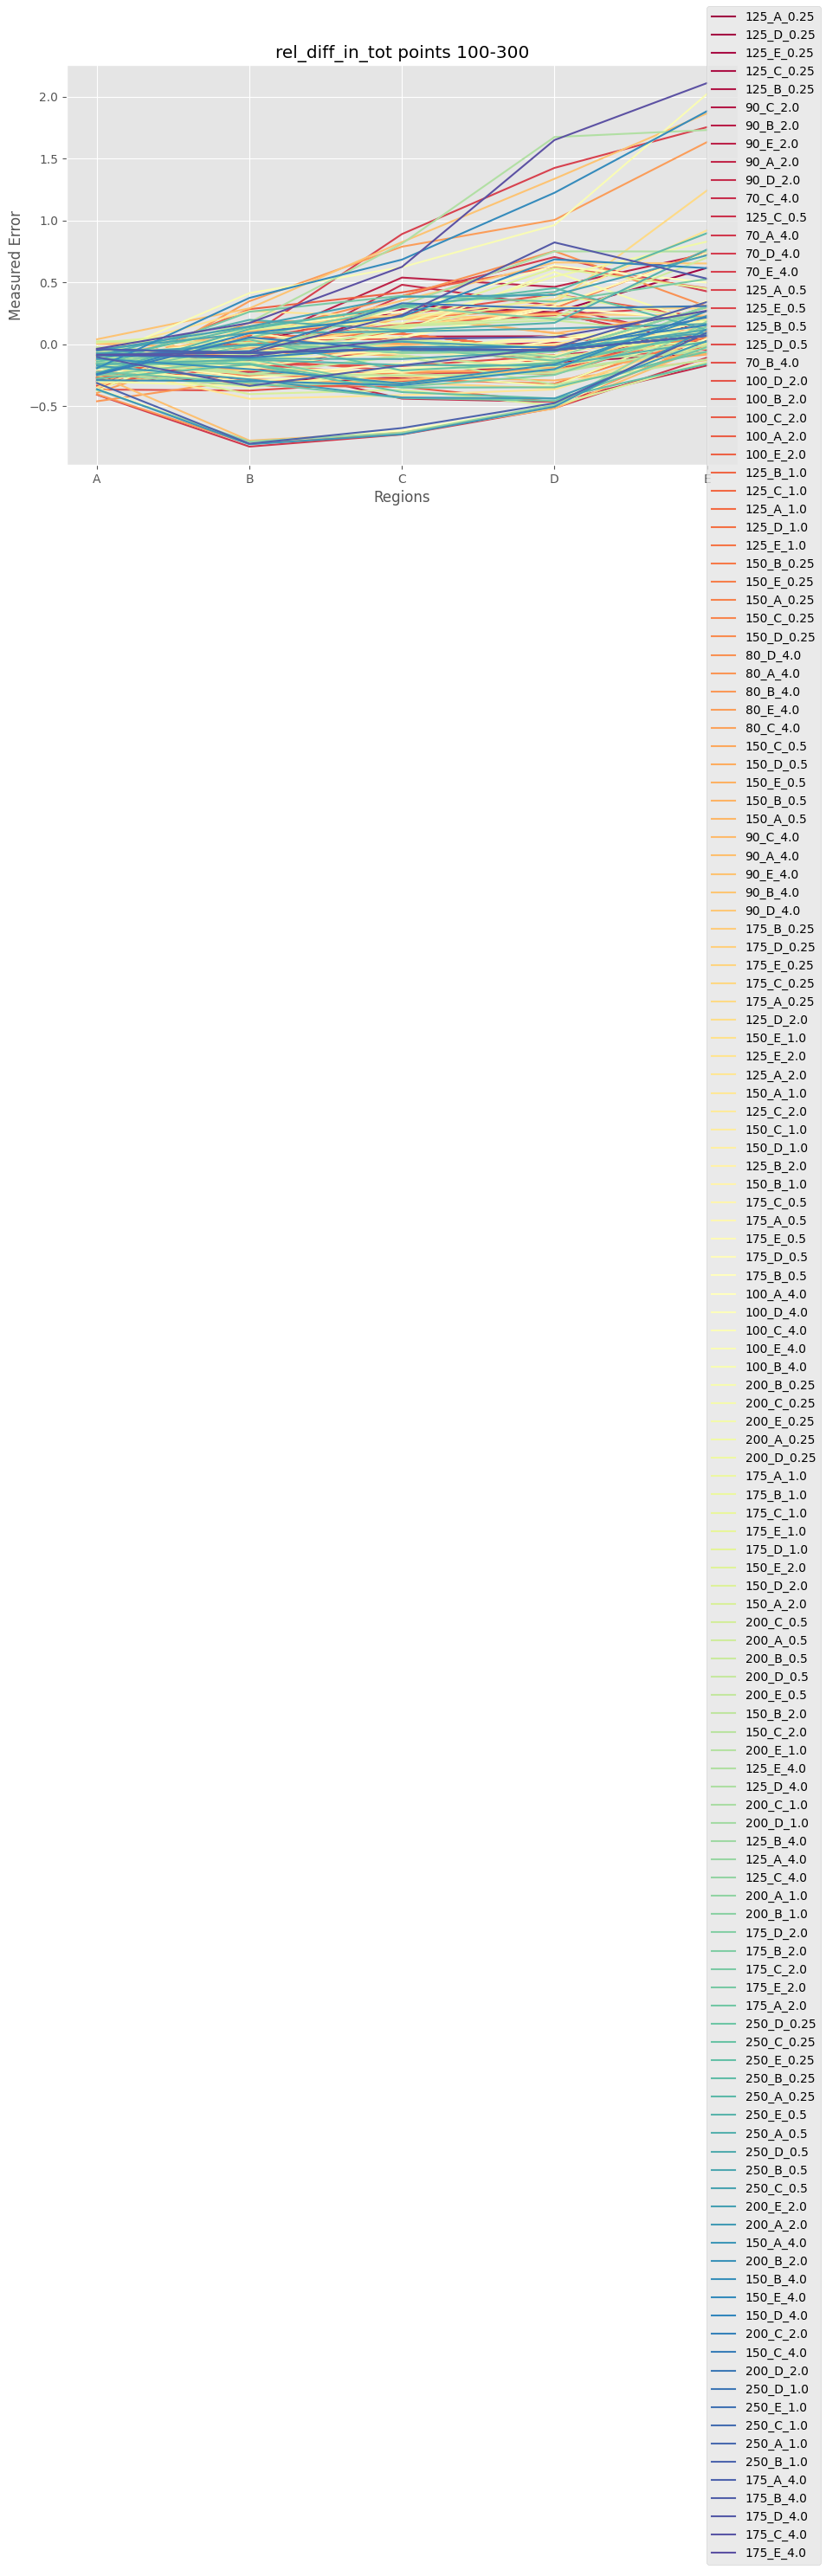

In [ ]:
test_df = df[(df["total_points"]>100)&(df["total_points"]<300)].sort_values("total_points")
plotter_2(test_df, "rel_diff_in_", "tot points 100-300")

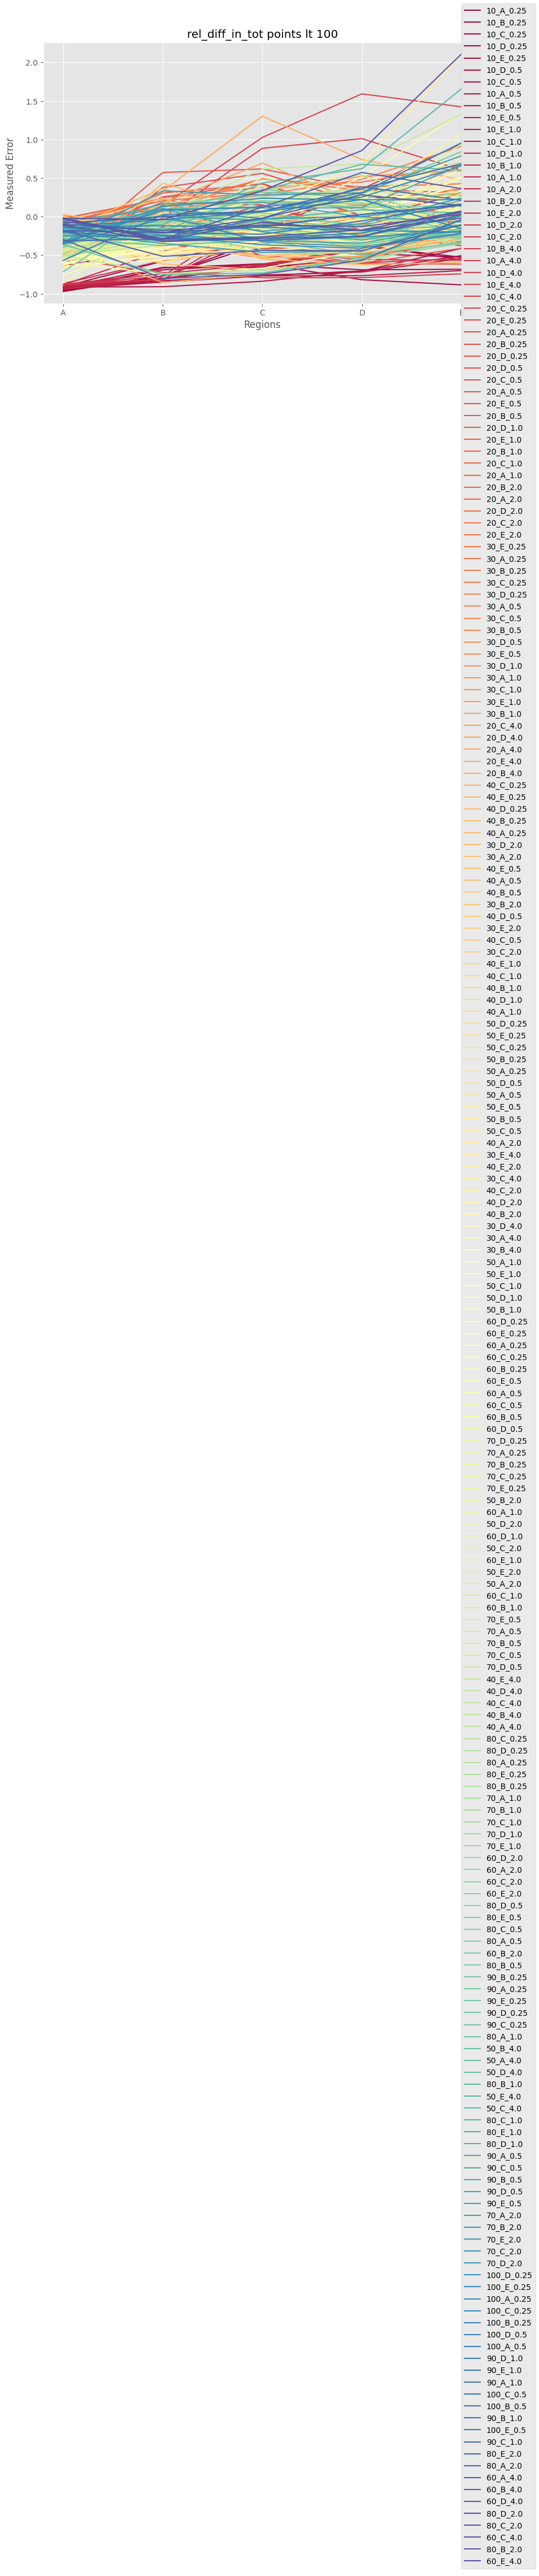

In [ ]:
test_df = df[df["total_points"]<100].sort_values("total_points")
plotter_2(test_df, "rel_diff_in_", "tot points lt 100")

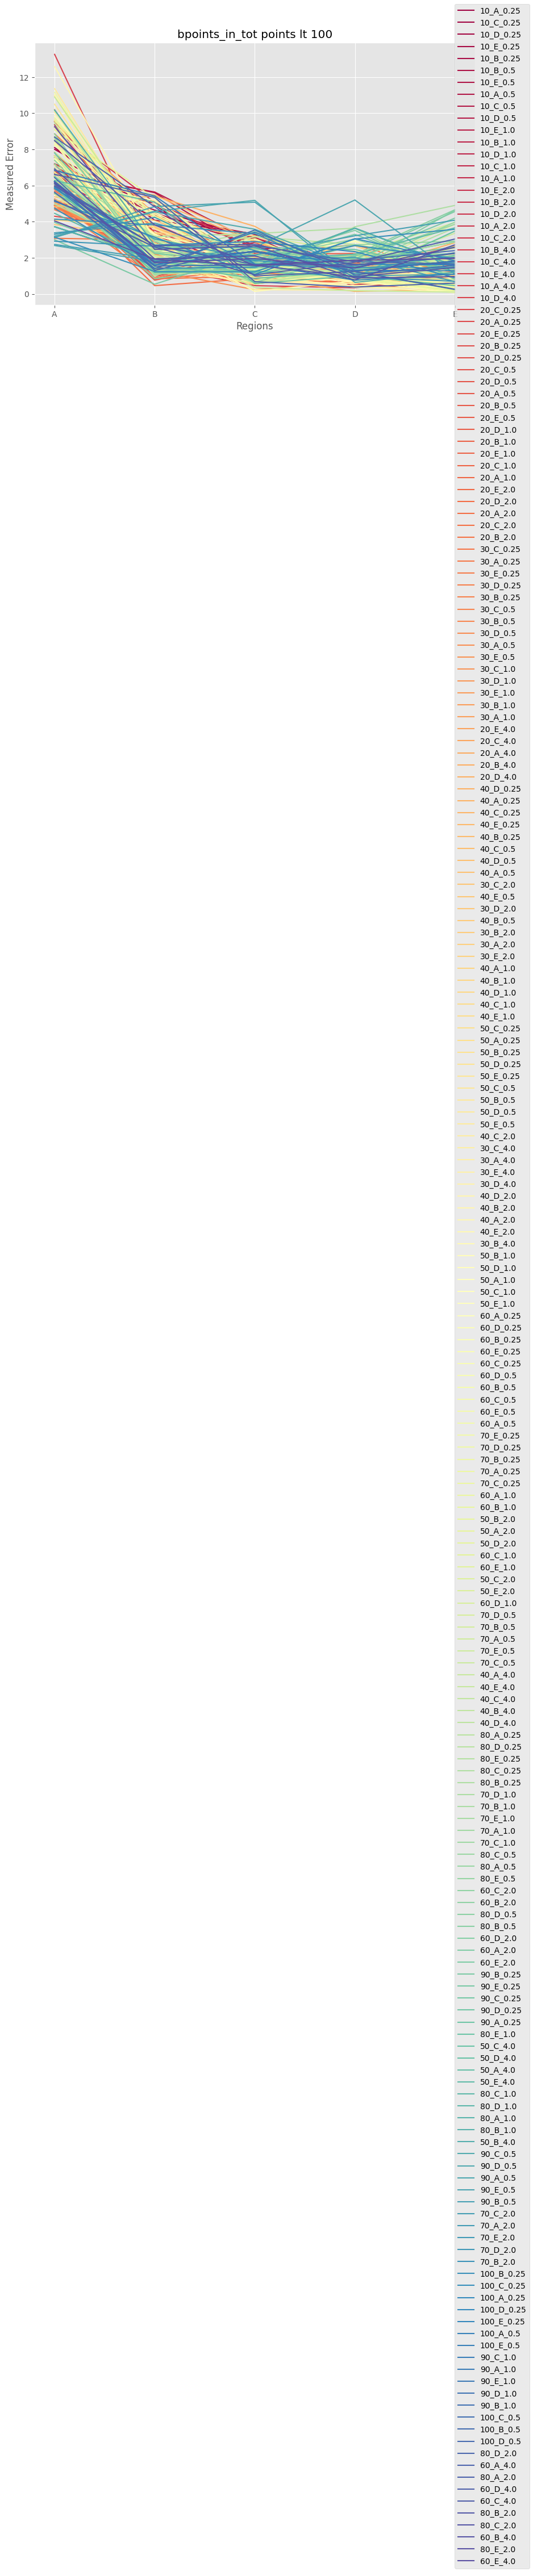

In [110]:
test_df = df[df["total_points"]<100].sort_values("total_points")
plotter_2(test_df, "bpoints_in_", "tot points lt 100")

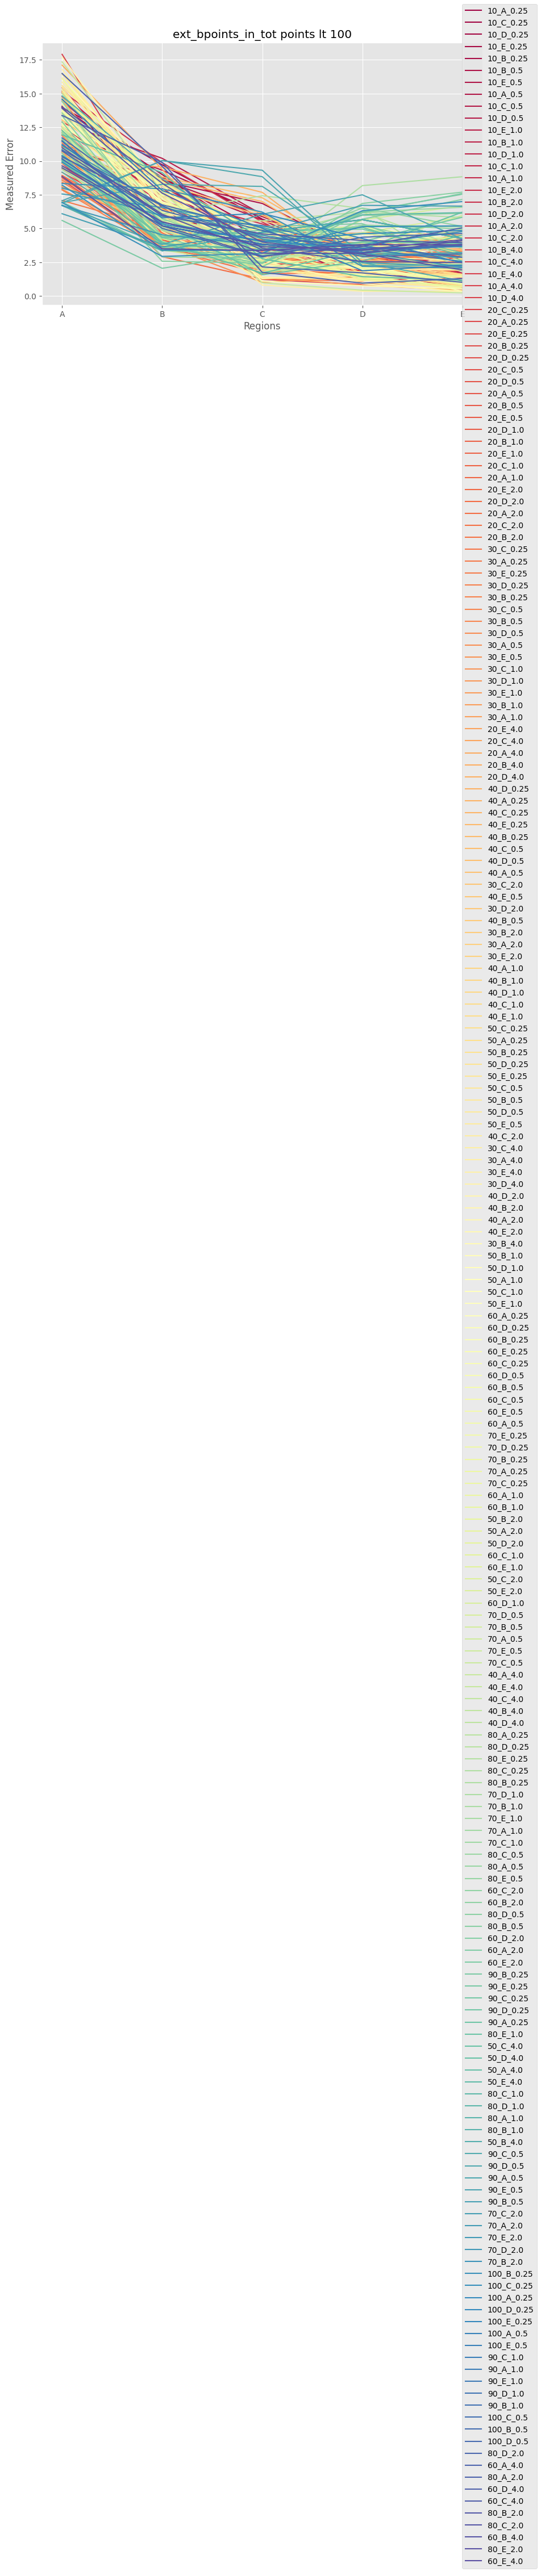

In [109]:
test_df = df[df["total_points"]<100].sort_values("total_points")
plotter_2(test_df, "ext_bpoints_in_", "tot points lt 100")

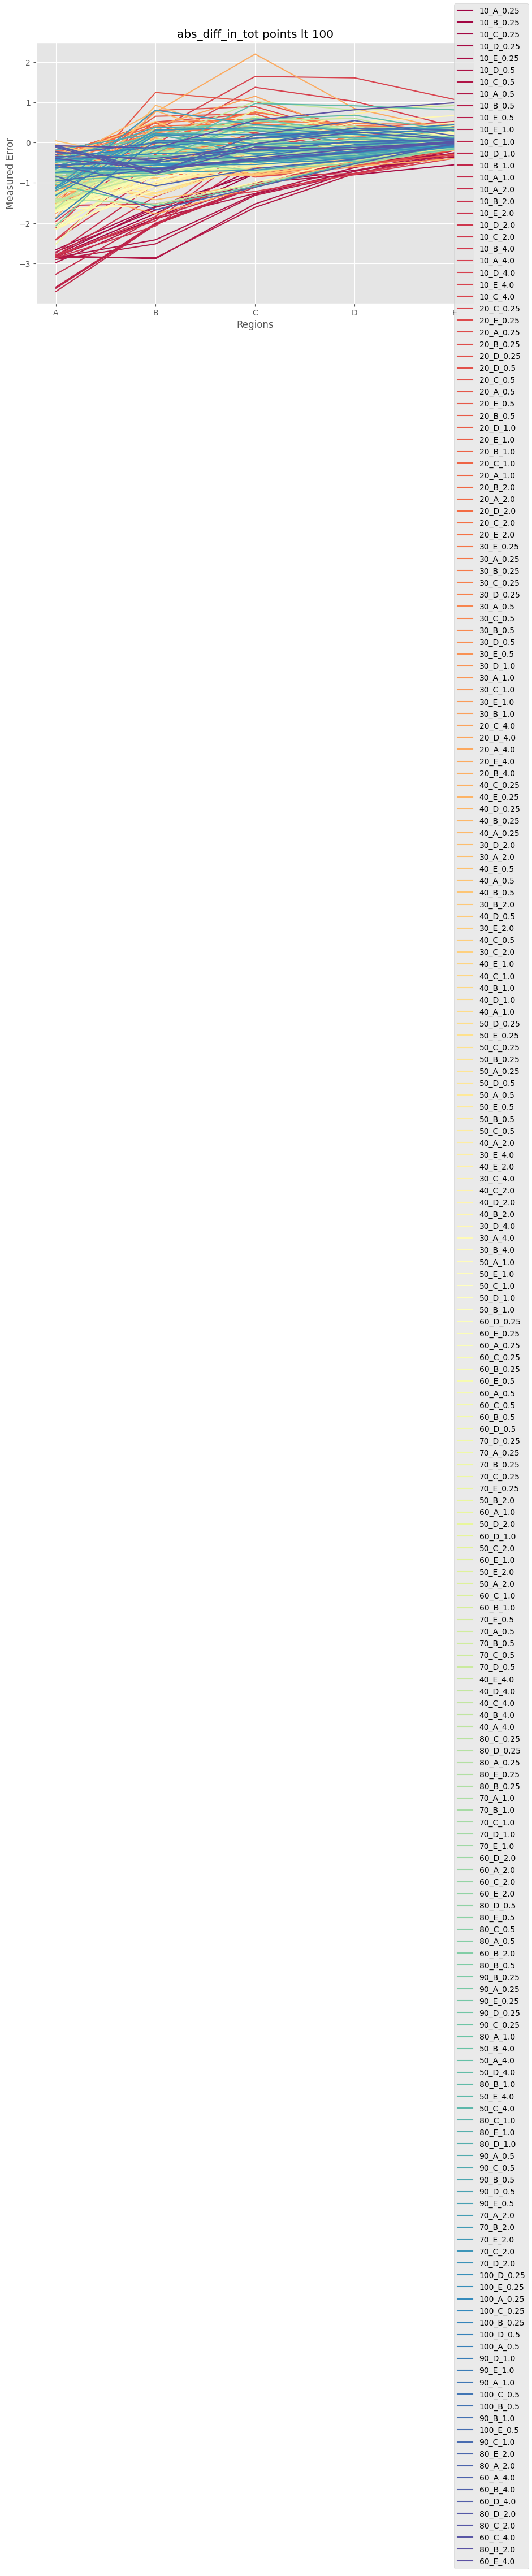

In [ ]:
test_df = df[df["total_points"]<100].sort_values("total_points")
plotter_2(test_df, "abs_diff_in_", "tot points lt 100")

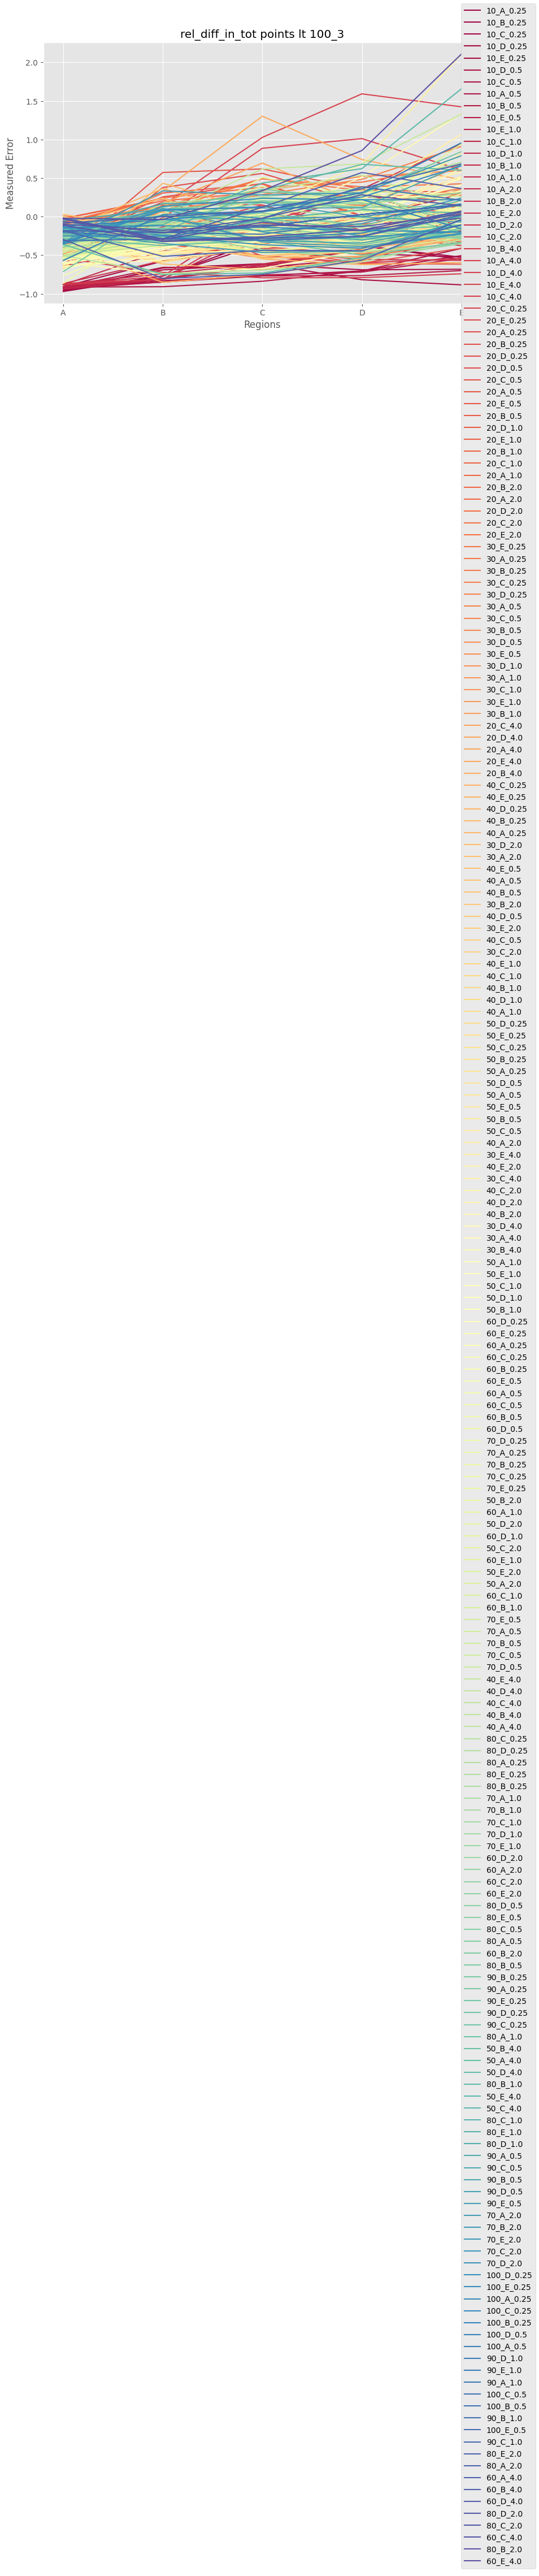

In [ ]:
test_df = df[df["total_points"]<100].sort_values("total_points")
plotter_2(test_df, "rel_diff_in_", "tot points lt 100_3")

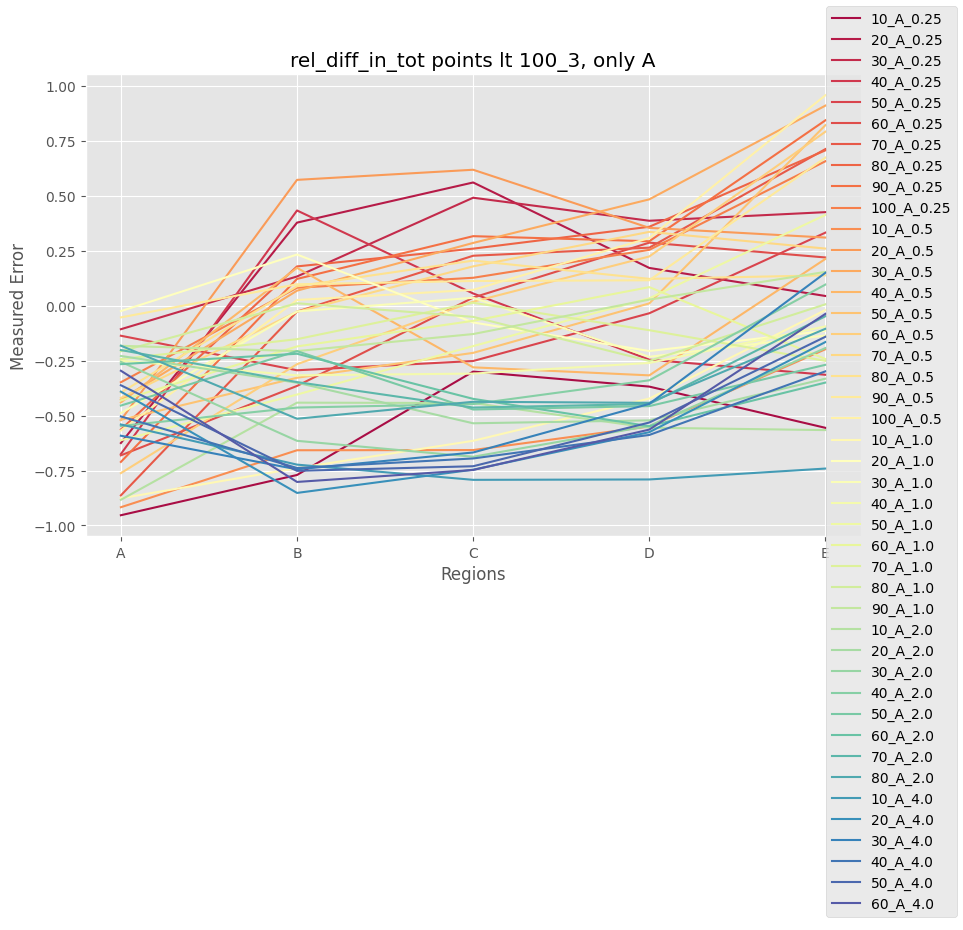

In [ ]:
test_df = df[(df["total_points"]<100)&(df["region"]=="A")].sort_values(["multiplier","total_points"])
plotter_2(test_df, "rel_diff_in_", "tot points lt 100_3, only A")

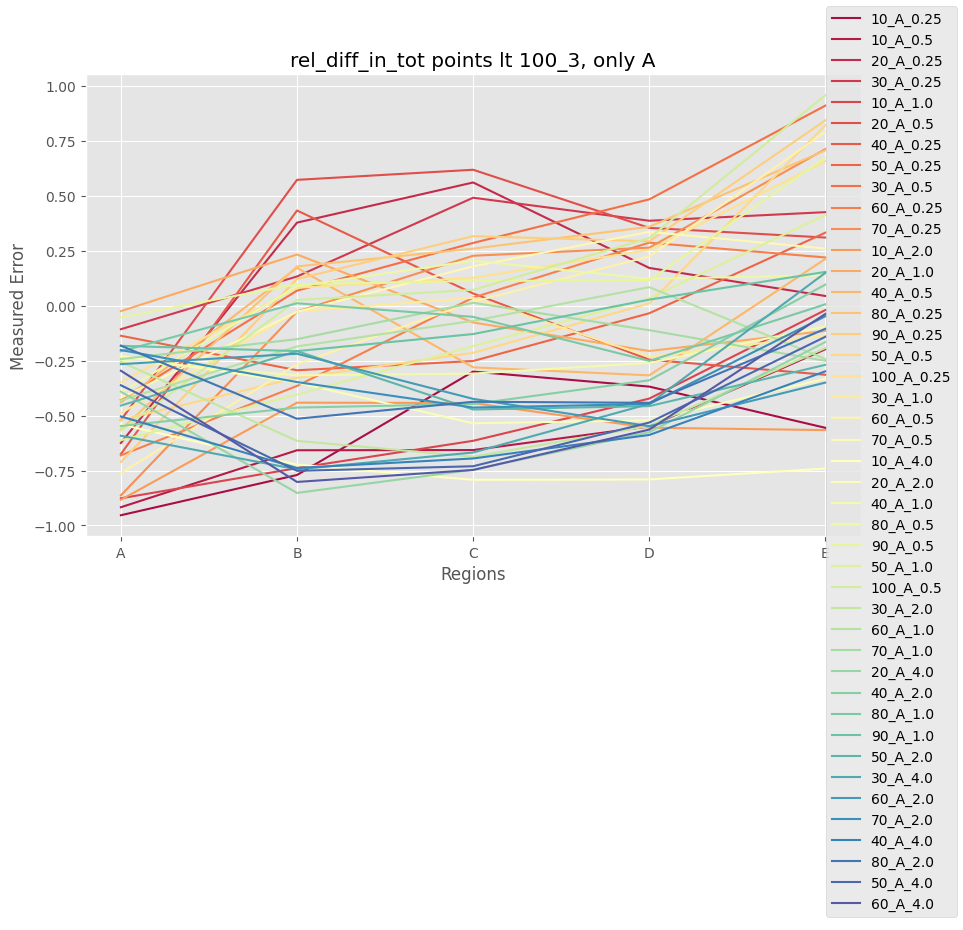

In [ ]:
test_df = df[(df["total_points"]<100)&(df["region"]=="A")].sort_values(["points_in_diff_region", "total_points"])
plotter_2(test_df, "rel_diff_in_", "tot points lt 100_3, only A")

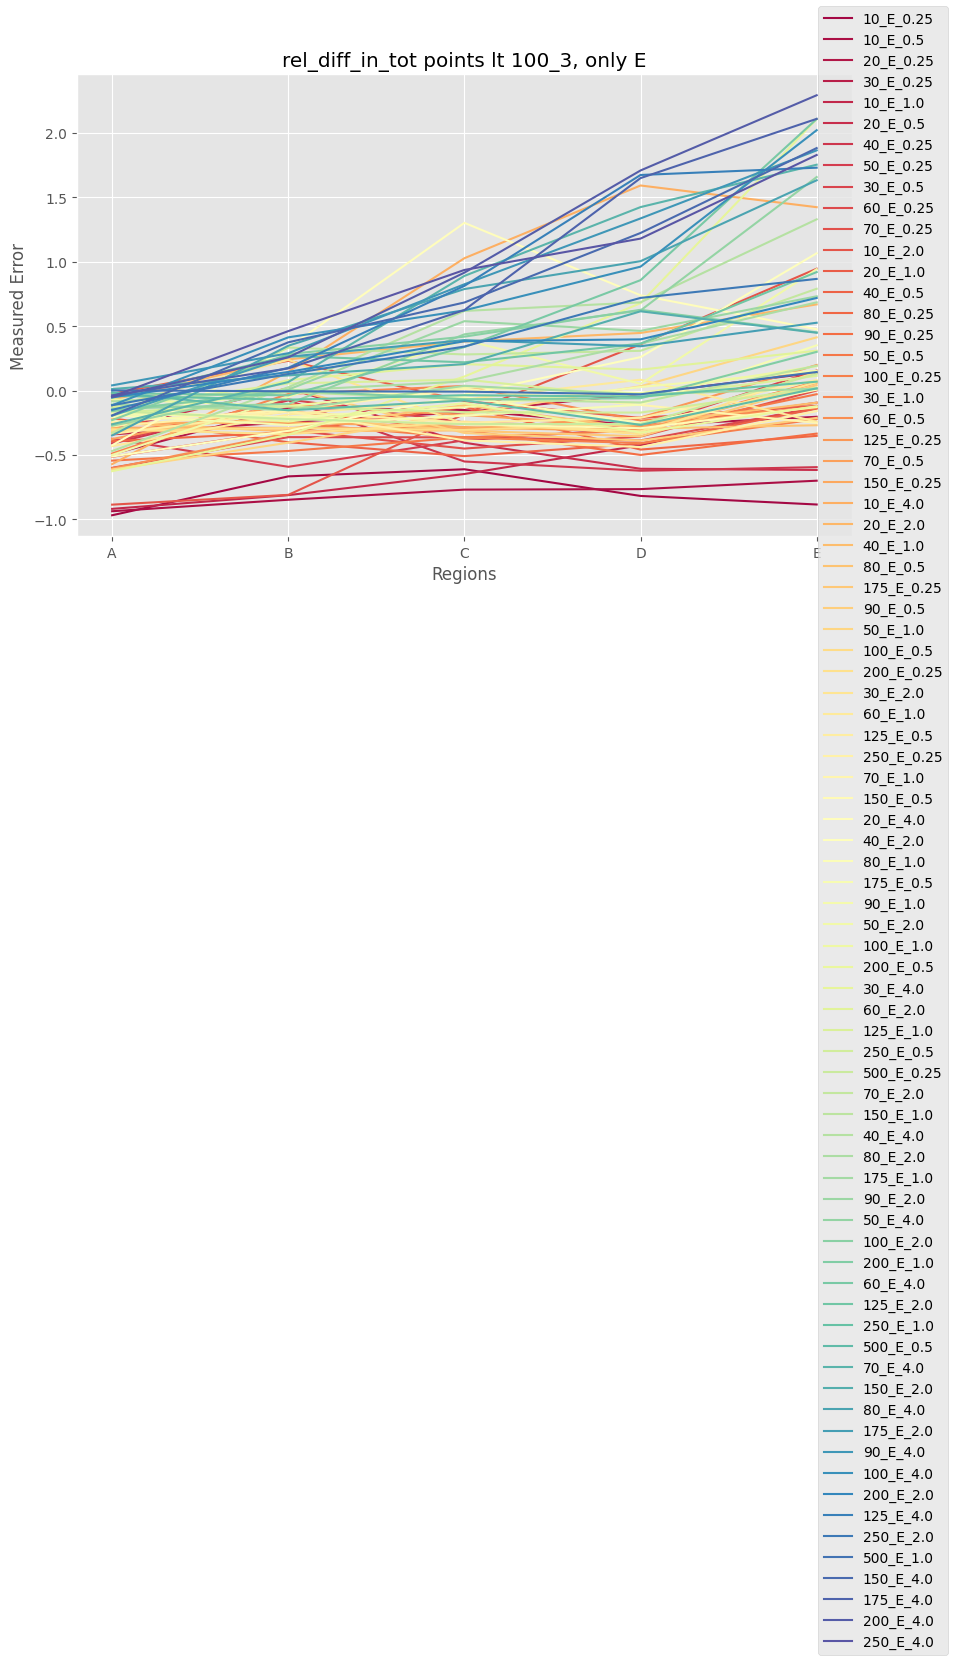

In [ ]:
test_df = df[(df["total_points"]<600)&(df["region"]=="E")].sort_values(["points_in_diff_region", "total_points"])
plotter_2(test_df, "rel_diff_in_", "tot points lt 100_3, only E")

In [ ]:
test_df[["combo_name", "points_in_diff_region", "total_points"]].tail(20)

combo_name  points_in_diff_region  total_points
446  100_E_2.0                   40.0         120.0
431  200_E_1.0                   40.0         200.0
461   60_E_4.0                   48.0          96.0
447  125_E_2.0                   50.0         150.0
432  250_E_1.0                   50.0         250.0
414  500_E_0.5                   50.0         450.0
462   70_E_4.0                   56.0         112.0
448  150_E_2.0                   60.0         180.0
463   80_E_4.0                   64.0         128.0
449  175_E_2.0                   70.0         210.0
464   90_E_4.0                   72.0         144.0
465  100_E_4.0                   80.0         160.0
450  200_E_2.0                   80.0         240.0
466  125_E_4.0                  100.0         200.0
451  250_E_2.0                  100.0         300.0
433  500_E_1.0                  100.0         500.0
467  150_E_4.0                  120.0         240.0
468  175_E_4.0                  140.0         280.0
469  200_E_4.0                  160.0         320.0
470  250_E_4.0                  200.0         400.0

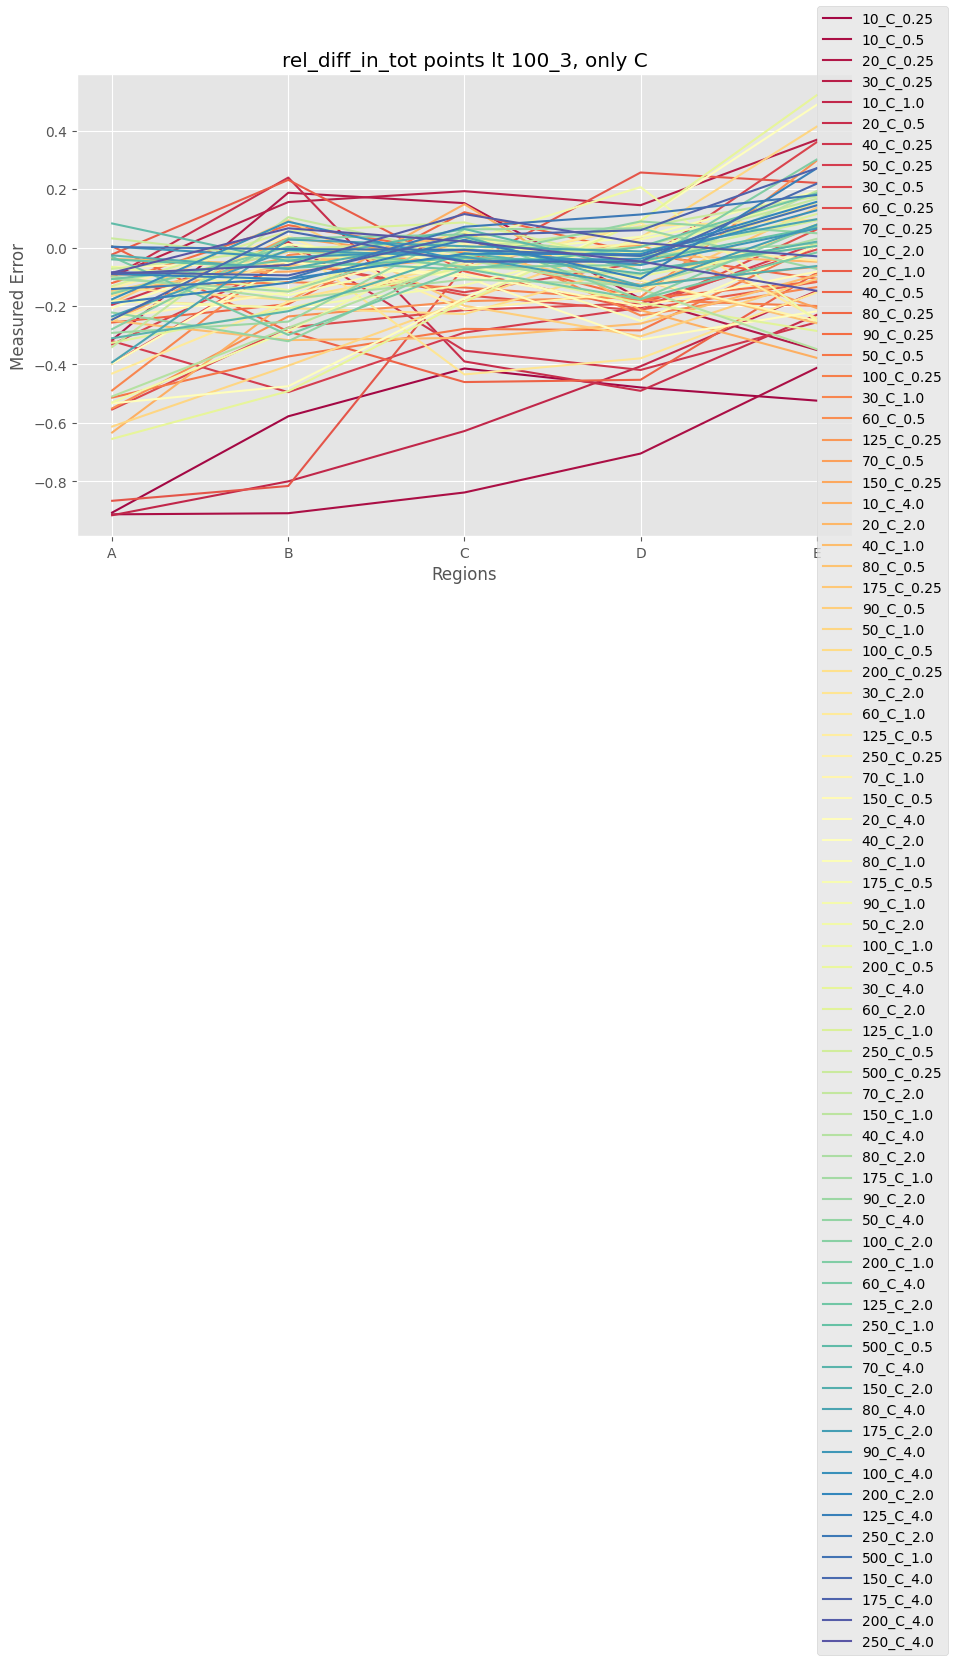

In [ ]:
test_df = df[(df["total_points"]<600)&(df["region"]=="C")].sort_values(["points_in_diff_region", "total_points"])
plotter_2(test_df, "rel_diff_in_", "tot points lt 100_3, only C")

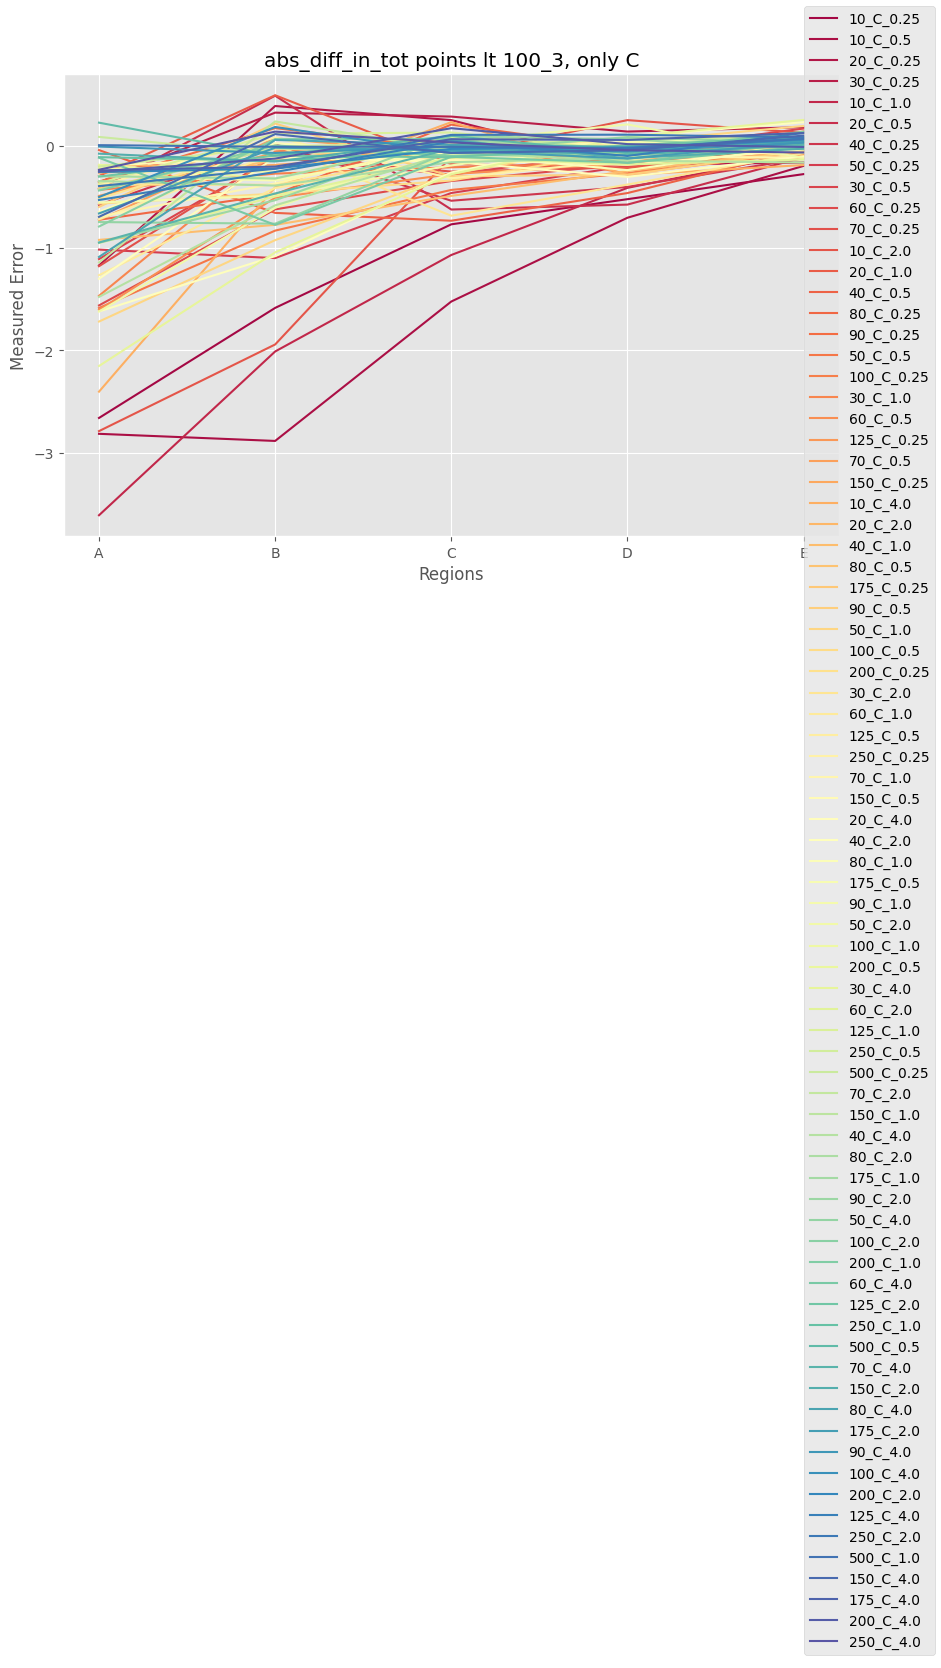

In [ ]:
test_df = df[(df["total_points"]<600)&(df["region"]=="C")].sort_values(["points_in_diff_region", "total_points"])
plotter_2(test_df, "abs_diff_in_", "tot points lt 100_3, only C")

In [ ]:
def plotter_3(df, y,title_additional=""):
    regions = ['A', 'B', 'C', 'D', 'E']

    fig, ax = plt.subplots(figsize=(10, 6))
    
    diverging_colors = sns.color_palette("Spectral", df.shape[0])
    # sns.palplot(diverging_colors)
    sns.scatterplot(data = df, x="points_in_diff_region_dummy",y=y )
    # for i, values in enumerate(df.iterrows()):
    #     ax.plot(values[1]["points_in_diff_region"], values[1]["abs_diff_in_c"], label=values[1]["combo_name"], color=diverging_colors[i])
        
    #     handles, labels = ax.get_legend_handles_labels()

    # ax.set_xlabel('Regions')
    # ax.set_ylabel('Measured Error')
    # ax.set_title(x+title_additional)
    # # ax.legend()
    
    
    # fig.legend(handles, labels, loc='upper right')
    
    plt.show()
    #fig.savefig(f"plots/ilusad/regions_and_{x}_{title_additional}.jpeg", dpi=300)

#test_df = df[df["total_points"]<600].sort_values("total_points")
#plotter_3(test_df, "abs_diff_in_", "asdf")

In [ ]:
round(123, -1)

120

In [ ]:
df[(df["points_in_diff_region"]>105)& (df["points_in_diff_region"]<180)&(df['region']=="C")].sort_values("points_in_diff_region")

region  multiplier  train_size  random_seed  bpoints_in_a  bpoints_in_b  \
277      C         4.0         150         24.5          4.34          5.52   
278      C         4.0         175         24.5          6.56          4.00   
244      C         1.0         750         24.5          6.36          3.92   
279      C         4.0         200         24.5          4.34          2.70   

     bpoints_in_c  bpoints_in_d  bpoints_in_e  ext_bpoints_in_a  \
277          1.38          0.86          2.98              9.80   
278          2.10          1.30          3.42             12.38   
244          2.22          2.08          3.72             12.28   
279          3.10          2.06          4.64              8.26   

     ext_bpoints_in_b  ext_bpoints_in_c  ext_bpoints_in_d  ext_bpoints_in_e  \
277              7.60              4.58              3.08              4.58   
278              6.94              4.54              4.60              4.34   
244              7.90              5.26              6.68              4.92   
279              5.32              5.68              7.66              6.60   

     abs_diff_in_a  abs_diff_in_b  abs_diff_in_c  abs_diff_in_d  \
277      -0.695893       0.112709      -0.071928      -0.045637   
278      -0.242548      -0.204796       0.062479       0.055552   
244      -0.290702      -0.143309       0.007850       0.013287   
279      -0.254551      -0.126554       0.170115       0.014879   

     abs_diff_in_e  rel_diff_in_a  rel_diff_in_b  rel_diff_in_c  \
277       0.098099      -0.246581       0.055249      -0.048375   
278       0.122849      -0.084510      -0.095372       0.042216   
244       0.088250      -0.106256      -0.068917       0.005261   
279      -0.013261      -0.090322      -0.059773       0.114428   

     rel_diff_in_d  rel_diff_in_e  raw_mean2_in_a  raw_mean2_in_b  \
277      -0.048360       0.218310        2.113023        2.206435   
278       0.059306       0.271127        2.563237        1.922505   
244       0.014218       0.198325        2.443038        1.934359   
279       0.016153      -0.029985        2.548761        1.988164   

     raw_mean2_in_c  raw_mean2_in_d  raw_mean2_in_e  raw_mean3_in_a  \
277        1.412894        0.897854        0.548173        2.808916   
278        1.543943        0.992437        0.577761        2.805785   
244        1.492992        0.950204        0.533227        2.733740   
279        1.657490        0.977363        0.435321        2.803311   

     raw_mean3_in_b  raw_mean3_in_c  raw_mean3_in_d  raw_mean3_in_e  \
277        2.093727        1.484823        0.943492        0.450075   
278        2.127301        1.481464        0.936885        0.454912   
244        2.077668        1.485142        0.936917        0.444977   
279        2.114718        1.487376        0.962484        0.448581   

     points_in_equal_regions  points_in_diff_region  total_points combo_name  
277                     30.0                  120.0         240.0  150_C_4.0  
278                     35.0                  140.0         280.0  175_C_4.0  
244                    150.0                  150.0         750.0  750_C_1.0  
279                     40.0                  160.0         320.0  200_C_4.0

In [ ]:
test_df = df.copy()
test_df = test_df[(test_df["region"]=="C")&(test_df["multiplier"]==4.0)]
test_df["points_in_diff_region_dummy"] = test_df["points_in_diff_region"].apply(lambda x: round(x/30,0)*30 )
test_df.value_counts("points_in_diff_region_dummy", sort=False)

points_in_diff_region_dummy
0.0       1
30.0      4
60.0      4
90.0      2
120.0     1
150.0     2
210.0     1
390.0     1
600.0     1
810.0     1
1590.0    1
dtype: int64

C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\3283683059.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_df = test_df[(test_df["region"]==letter)&(test_df["multiplier"]==2)].groupby(["points_in_diff_region_dummy"]).mean().reset_index()


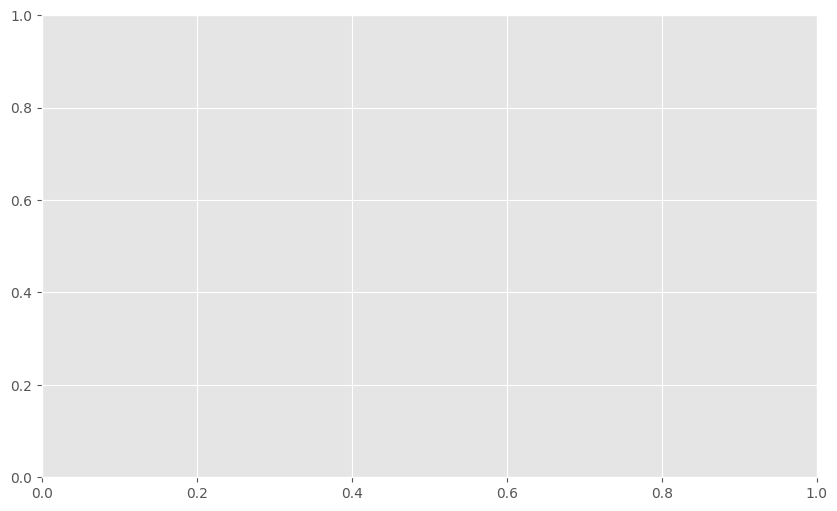

In [ ]:
#test_df = df.copy()
letter = "B"
#test_df["points_in_diff_region_dummy"] = test_df["points_in_diff_region"].apply(lambda x: round(x/10,0)*10 )
test_df = test_df[(test_df["region"]==letter)&(test_df["multiplier"]==2)].groupby(["points_in_diff_region_dummy"]).mean().reset_index()
plotter_3(test_df, "rel_diff_in_"+letter.lower(), "asdf")

In [ ]:
df = big_df.copy()

C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\3181718062.py:2: RuntimeWarning: divide by zero encountered in divide
  y = 1/x


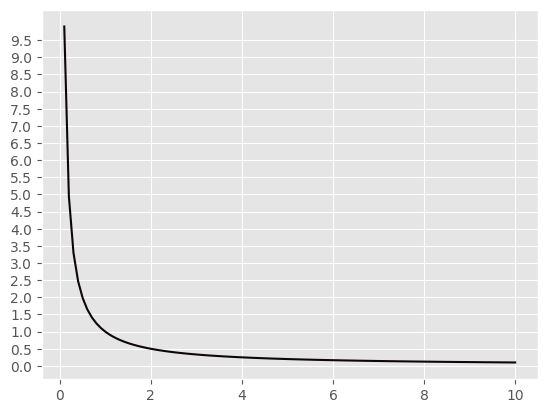

In [ ]:
x = np.linspace(0, 10, 100)
y = 1/x
plt.yticks(np.arange(0, 10, 0.5))
plt.plot(x, y)

C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\3058385743.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_df = test_df[(test_df["region"]==letter)&(test_df["multiplier"]==2)].groupby(["points_in_diff_region_dummy"]).mean().reset_index()
C:\Users\troosma\AppData\Local\Temp\ipykernel_36972\3058385743.py:9: UserWarning: The palette list has more values (37) than needed (19), which may not be intended.
  sns.scatterplot(data = df, x="points_in_diff_region",y=y, hue="points_in_diff_region",markers="multiplier", palette=diverging_colors )


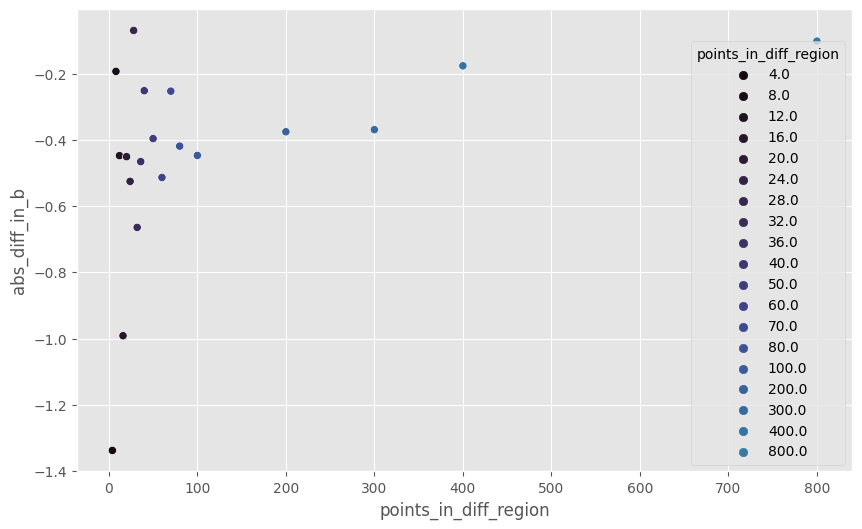

In [ ]:
def plotter_4(df, y,title_additional=""):
    regions = ['A', 'B', 'C', 'D', 'E']

    fig, ax = plt.subplots(figsize=(10, 6))
    
    diverging_colors = sns.color_palette("mako", df.shape[1])
    # plt.yscale('function', functions=(lambda y: 1/(y+1), lambda y: 1/(y+1)))

    sns.scatterplot(data = df, x="points_in_diff_region",y=y, hue="points_in_diff_region",markers="multiplier", palette=diverging_colors )

    plt.show()


letter = "B"
test_df = df.copy()
test_df["points_in_diff_region_dummy"] = test_df["points_in_diff_region"].apply(lambda x: round(x/2,0)*2)
test_df = test_df[(test_df["region"]==letter)&(test_df["multiplier"]==2)].groupby(["points_in_diff_region_dummy"]).mean().reset_index()

plotter_4(test_df, "abs_diff_in_"+letter.lower(), "asdf")

In [ ]:
megaplotty(df, "abs_diff_in_", "asdf")

TypeError: megaplotty() missing 2 required positional arguments: 'y_letter' and 'df'

<AxesSubplot: xlabel='points_in_equal_regions', ylabel='bpoints_in_a'>

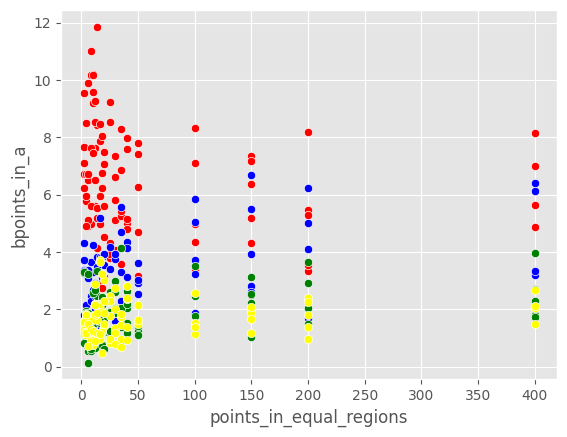

In [124]:
test_df = df[df.region=="B"]
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="bpoints_in_a",color="red")
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="bpoints_in_b",color="blue")
# sns.scatterplot(data = test_df, x="points_in_equal_regions",y="bpoints_in_c",color="green")
# sns.scatterplot(data = test_df, x="points_in_equal_regions",y="bpoints_in_d",color="yellow")

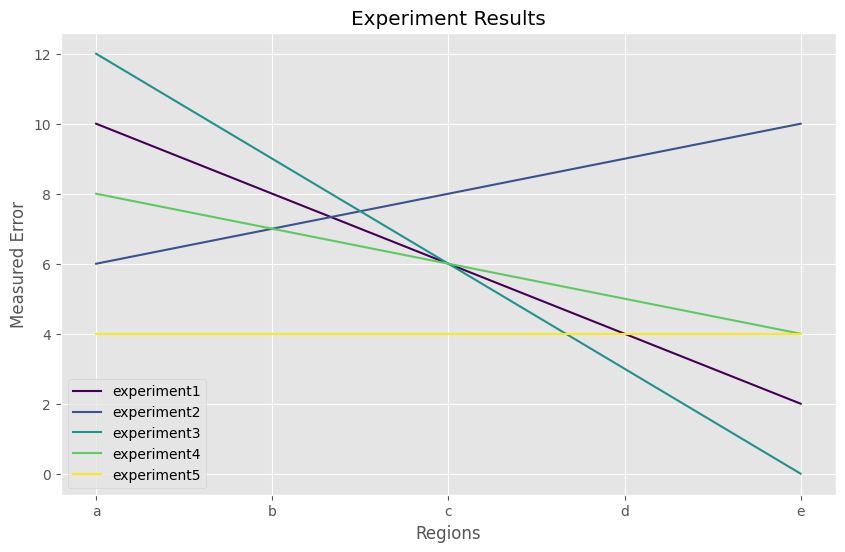

In [ ]:
# create a list of the regions
regions = ['a', 'b', 'c', 'd', 'e']

# create a dictionary with the experiment results
experiments = {
    'experiment1': [10, 8, 6, 4, 2],
    'experiment2': [6, 7, 8, 9, 10],
    'experiment3': [12, 9, 6, 3, 0],
    'experiment4': [8, 7, 6, 5, 4],
    'experiment5': [4, 4, 4, 4, 4]
}

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# loop through the experiments and plot each line
for experiment, values in experiments.items():
    ax.plot(regions, values, label=experiment)

# set the axis labels and legend
ax.set_xlabel('Regions')
ax.set_ylabel('Measured Error')
ax.set_title('Experiment Results')
ax.legend()

# show the plot
plt.show()

In [ ]:
df[(df['region'] == 'A')&(df['multiplier'] == 0.25)&(df['train_size'] == 10)].mean()

C:\Users\troosma\AppData\Local\Temp\ipykernel_29144\3649948254.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[(df['region'] == 'A')&(df['multiplier'] == 0.25)&(df['train_size'] == 10)].mean()


train_size                 10.000000
random_seed                 2.000000
multiplier                  0.250000
bpoints_in_a                7.000000
bpoints_in_b                4.600000
bpoints_in_c                2.400000
bpoints_in_d                0.400000
bpoints_in_e                0.000000
ext_bpoints_in_a           13.600000
ext_bpoints_in_b            8.600000
ext_bpoints_in_c            3.600000
ext_bpoints_in_d            1.200000
ext_bpoints_in_e            0.800000
abs_diff_in_a              -0.348758
abs_diff_in_b              -0.741961
abs_diff_in_c              -0.550995
abs_diff_in_d              -1.424963
abs_diff_in_e              -2.297287
rel_diff_in_a              -1.683384
rel_diff_in_b              -1.660356
rel_diff_in_c              -1.290814
rel_diff_in_d              -1.590685
rel_diff_in_e              -1.804457
raw_mean2_in_a              0.318286
raw_mean2_in_b              0.447277
raw_mean2_in_c              1.290214
raw_mean2_in_d              0.975585
r

In [ ]:
df_2 = df.groupby(['region', 'multiplier', 'train_size']).mean().reset_index()
df_2
# df_2.reset_index(inplace=True)
# sns.barplot(x='A', y='B', data=df_2);



region  multiplier  train_size  random_seed  bpoints_in_a  bpoints_in_b  \
0        A        0.25          10          2.0           7.0           4.6   
1        A        0.25          20          2.0           5.6           2.4   
2        A        0.25          30          2.0           3.4           6.6   
3        A        0.25          40          2.0           6.6           4.8   
4        A        0.25          50          2.0           6.6           2.6   
..     ...         ...         ...          ...           ...           ...   
468      E        4.00         200          2.0           7.4           3.0   
469      E        4.00         250          2.0           7.4           5.6   
470      E        4.00         500          2.0           8.0           3.6   
471      E        4.00         750          2.0           8.6           2.8   
472      E        4.00        1000          2.0           5.8           3.8   

     bpoints_in_c  bpoints_in_d  bpoints_in_e  ext_bpoints_in_a  ...  \
0             2.4           0.4           0.0              13.6  ...   
1             0.6           0.2           0.0              11.2  ...   
2             1.8           0.0           0.0              11.6  ...   
3             1.6           0.2           0.2              13.2  ...   
4             1.4           0.6           0.0              13.4  ...   
..            ...           ...           ...               ...  ...   
468           3.2           0.2           0.0              12.8  ...   
469           0.8           0.2           0.0              15.2  ...   
470           1.8           0.2           0.0              15.6  ...   
471           0.8           0.8           0.0              14.8  ...   
472           1.8           0.6           0.6              12.4  ...   

     raw_mean2_in_d  raw_mean2_in_e  raw_mean3_in_a  raw_mean3_in_b  \
0          0.975585        0.557305        0.667044        1.189238   
1          2.254769        2.780720        0.596274        1.006193   
2          2.252303        2.615842        0.489134        1.159714   
3          1.369364        1.822075        0.549896        1.091912   
4          1.715328        2.391290        0.632477        1.036879   
..              ...             ...             ...             ...   
468        2.171438        2.767723        0.466392        1.002370   
469        1.989307        2.553435        0.456908        1.003442   
470        1.992869        2.694847        0.450068        1.002667   
471        2.116842        2.674646        0.449841        0.990946   
472        2.036091        2.617995        0.447579        0.993425   

     raw_mean3_in_c  raw_mean3_in_d  raw_mean3_in_e  points_in_equal_regions  \
0          1.841209        2.400548        2.854592                      2.0   
1          1.544099        2.174497        2.775782                      4.0   
2          1.536453        2.235472        3.084342                      6.0   
3          1.580449        2.259144        3.000289                      8.0   
4          1.562713        2.156092        2.772477                     10.0   
..              ...             ...             ...                      ...   
468        1.516076        2.107233        2.708951                     40.0   
469        1.527225        2.112613        2.697559                     50.0   
470        1.517737        2.105580        2.669842                    100.0   
471        1.511899        2.101476        2.671087                    150.0   
472        1.514102        2.101876        2.674023                    200.0   

     points_in_diff_region  total_points  
0                      0.0           8.0  
1                      1.0          17.0  
2                      1.0          25.0  
3                      2.0          34.0  
4                      2.0          42.0  
..                     ...           ...  
468                  160.0         320.0  
469                  200.0      

<AxesSubplot: xlabel='abs_diff_in_b', ylabel='raw_mean2_in_b'>

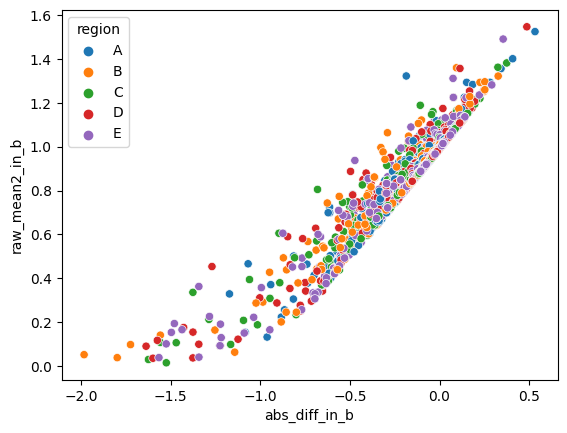

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(ax=ax[0], data=df, x="abs_diff_in_a",y="raw_mean2_in_a", hue="region",)
sns.scatterplot(ax=ax[1], data=df, x="abs_diff_in_a",y="raw_mean3_in_a", hue="region",)

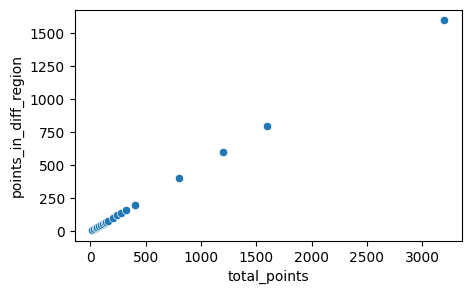

In [ ]:
letter = "C"
test_df = df.copy()
test_df["points_in_diff_region_dummy"] = test_df["points_in_diff_region"].apply(lambda x: round(x/1,0)*1)
test_df = test_df[(test_df["region"]=="C")&(test_df["multiplier"]==4)].groupby(["points_in_diff_region_dummy"]).mean(numeric_only=True).reset_index()

regions = ['A', 'B', 'C', 'D', 'E']
fig, ax = plt.subplots(figsize=(5, 3))
diverging_colors = sns.color_palette("mako", test_df.shape[1])

sns.scatterplot(data = test_df, x="total_points",y="points_in_diff_region")

plt.show()



In [ ]:
len([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 500, 750, 1000, 2000])

19

<AxesSubplot: xlabel='points_in_diff_region', ylabel='rel_diff_in_a'>

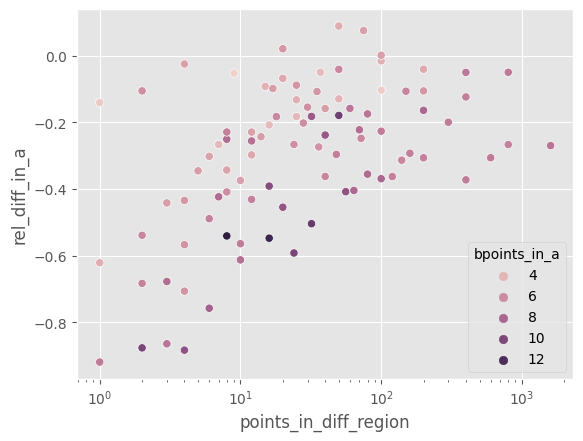

In [125]:
test_df = df[(df.region=="A")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots()
ax.set_xscale( "log")
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a",hue="bpoints_in_a",ax=ax)#hue_norm=LogNorm() )
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_b",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_c",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_d",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_e",hue="multiplier")

<AxesSubplot: xlabel='points_in_diff_region', ylabel='rel_diff_in_c'>

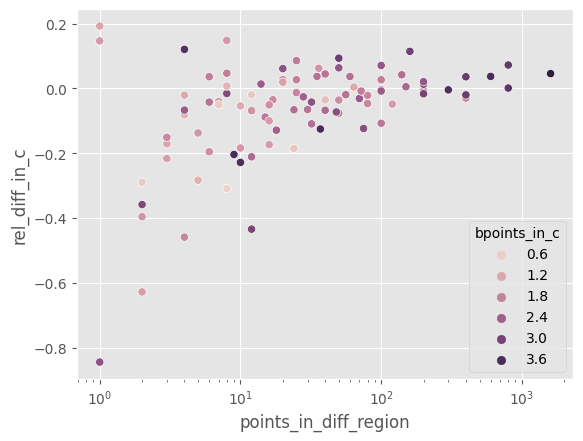

In [126]:
test_df = df[(df.region=="C")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots()
ax.set_xscale( "log")
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c",hue="bpoints_in_c",ax=ax)#hue_norm=LogNorm() )
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_b",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_c",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_d",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_e",hue="multiplier")

<AxesSubplot: xlabel='points_in_diff_region', ylabel='rel_diff_in_e'>

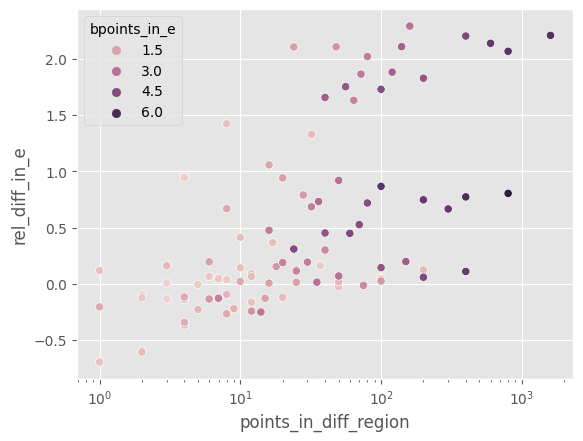

In [127]:
test_df = df[(df.region=="E")&(df.points_in_diff_region!=0)]
fig, ax = plt.subplots()
ax.set_xscale( "log")
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e",hue="bpoints_in_e",ax=ax)#hue_norm=LogNorm() )
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_b",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_c",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_d",hue="multiplier")
# sns.scatterplot(data = test_df, x="bpoints_in_",y="rel_diff_in_e",hue="multiplier")